<a href="https://colab.research.google.com/github/aarsanjani/meansquares/blob/master/CA_LabelingData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Workflow

This colab aims in labeling the CA data for super spread week, safe week and improvement week as per the 'number of cases' increasing or decreasing every week.

Idea: 
* compute 7 -day moving average
* 14 days data compare with next 14 days rolling window
* split the % as buckets 
* label the data as per bucket

In [107]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [108]:
import pandas as pd

from tqdm import tqdm
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
from pandas import Series, datetime
from pandas.plotting import scatter_matrix, autocorrelation_plot
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import roc_curve, auc
import random
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from xgboost import XGBClassifier
from sklearn.mixture import GaussianMixture

In [109]:
os.environ["TF_CPP_MIN_LOG_LEVEL"]="2"
import warnings; warnings.simplefilter('ignore')


In [110]:
!ls  '/content/drive/Shared drives/CMPE 295- Master Project/Covid19-data/'

CA_combined_Sep09.csv		     CA_sd_inertia_labeledData_Sep25.csv
CA_combined_Sep25.csv		     CA_socialDistancingInertiaData_Sep09.csv
CA-CovidAug22.csv		     CA_socialDistancingInertiaData_Sep25.csv
CA_labeledData_Sep09		     Maryland_University_SocialDistancing_Data
CA_labeledData_Sep18.csv	     mask_rule.csv
CA_labeledData_Sep20.csv	     Newyork_combinedAug22.csv
CA_labeledData_Sep22.csv	     NY_sd_inertia_labeledData_Aug26.csv
CA_labeledData_Sep25.csv	     NY_socialDistancingInertiaDataAug25.csv
CA_labeledData_Sep26.csv	     Social_Distancing_Inertia_County.csv
CA_sd_inertia_labeledData_Sep09      TX_combined_Sep10.csv
CA_sd_inertia_labeledData_Sep18.csv  TX-Covid_Sep10.csv
CA_sd_inertia_labeledData_Sep20.csv  TX_socialDistancingInertiaData_Sep10.csv
CA_sd_inertia_labeledData_Sep22.csv


# 1.1 Loading CA data

In [111]:
CA_combined_data = pd.read_csv('/content/drive/Shared drives/CMPE 295- Master Project/Covid19-data/CA_combined_Sep25.csv',low_memory=False)
CA_combined_data.head()

,Date,fips_x,County Name,population,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases
0,2020-03-01,6001,Alameda County,1671329,6.0,9.0,15.0,1.0,4.0,0.0,-7.65,3.684,58,2261.547725,0,0.0,0
1,2020-03-02,6001,Alameda County,1671329,4.0,7.0,7.0,-1.0,3.0,0.0,6.76,6.182,98,2261.547725,0,0.0,0
2,2020-03-03,6001,Alameda County,1671329,5.0,12.0,41.0,0.0,1.0,-1.0,13.19,6.271,100,2261.547725,0,0.0,1
3,2020-03-04,6001,Alameda County,1671329,1.0,6.0,23.0,-3.0,1.0,0.0,10.67,6.209,99,2261.547725,0,0.0,0
4,2020-03-05,6001,Alameda County,1671329,1.0,6.0,12.0,-5.0,-1.0,1.0,11.64,6.654,106,2261.547725,0,0.0,0


## Computing rolling average

In [112]:
CA_combined_data.iloc[:,15]

0       0.000
1       0.000
2       0.000
3       0.000
4       0.000
        ...  
9191    0.669
9192    0.669
9193    0.669
9194    0.669
9195    0.669
Name: mask_wearing_percent, Length: 9196, dtype: float64

In [113]:
df = pd.DataFrame(columns=['Date','fips_x','County Name','retail and recreation','grocery and pharmacy','parks','transit stations','workplaces','residential','driving','m50','m50_index','population_density','mask_rule_active','mask_wearing_percent','New cases','rolling_avg_new_cases'])


In [114]:
CA_counties = CA_combined_data['County Name'].unique()

for county in CA_counties:
  county_data = CA_combined_data[CA_combined_data['County Name'] == county]
  #print(county_data.iloc[:,15])
  county_data['rolling_avg_new_cases'] = county_data.iloc[:,15].rolling(window=7).mean()
  df = df.append(county_data)

df.head()

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases,population
0,2020-03-01,6001,Alameda County,6.0,9.0,15.0,1.0,4.0,0.0,-7.65,3.684,58,2261.547725,0,0.0,0,NaN,1671329.0
1,2020-03-02,6001,Alameda County,4.0,7.0,7.0,-1.0,3.0,0.0,6.76,6.182,98,2261.547725,0,0.0,0,NaN,1671329.0
2,2020-03-03,6001,Alameda County,5.0,12.0,41.0,0.0,1.0,-1.0,13.19,6.271,100,2261.547725,0,0.0,1,NaN,1671329.0
3,2020-03-04,6001,Alameda County,1.0,6.0,23.0,-3.0,1.0,0.0,10.67,6.209,99,2261.547725,0,0.0,0,NaN,1671329.0
4,2020-03-05,6001,Alameda County,1.0,6.0,12.0,-5.0,-1.0,1.0,11.64,6.654,106,2261.547725,0,0.0,0,NaN,1671329.0


In [115]:
print(df.shape)
CA_combined_data.shape

(9196, 18)


(9196, 17)

In [116]:
CA_combined_data = df.copy()
CA_combined_data

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases,population
0,2020-03-01,6001,Alameda County,6.0,9.0,15.0,1.0,4.0,0.0,-7.65,3.684,58,2261.547725,0,0.000,0,NaN,1671329.0
1,2020-03-02,6001,Alameda County,4.0,7.0,7.0,-1.0,3.0,0.0,6.76,6.182,98,2261.547725,0,0.000,0,NaN,1671329.0
2,2020-03-03,6001,Alameda County,5.0,12.0,41.0,0.0,1.0,-1.0,13.19,6.271,100,2261.547725,0,0.000,1,NaN,1671329.0
3,2020-03-04,6001,Alameda County,1.0,6.0,23.0,-3.0,1.0,0.0,10.67,6.209,99,2261.547725,0,0.000,0,NaN,1671329.0
4,2020-03-05,6001,Alameda County,1.0,6.0,12.0,-5.0,-1.0,1.0,11.64,6.654,106,2261.547725,0,0.000,0,NaN,1671329.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9191,2020-08-17,6115,Yuba County,0.0,0.0,0.0,0.0,-34.0,7.0,64.29,4.100,43,124.506204,1,0.669,0,0.669,78668.0
9192,2020-08-18,6115,Yuba County,0.0,0.0,0.0,0.0,-32.0,8.0,54.39,4.944,52,124.506204,1,0.669,28,0.669,78668.0
9193,2020-08-19,6115,Yuba County,0.0,0.0,0.0,0.0,-33.0,8.0,61.72,4.090,43,124.506204,1,0.669,35,0.669,78668.0
9194,2020-08-20,6115,Yuba County,0.0,0.0,0.0,0.0,-33.0,8.0,59.48,4.096,43,124.506204,1,0.669,0,0.669,78668.0


In [117]:
CA_combined_data[CA_combined_data['Date'] == '2020-08-01']

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases,population
151,2020-08-01,6001,Alameda County,-44.0,-13.0,28.0,-49.0,-19.0,9.0,9.45,1.041,16,2261.547725,1,0.795,345,0.795,1671329.0
323,2020-08-01,6005,Amador County,-9.0,12.0,0.0,0.0,-15.0,0.0,123.25,2.433,18,66.857277,1,0.655,10,0.655,39752.0
495,2020-08-01,6007,Butte County,-21.0,2.0,39.0,0.0,-15.0,3.0,55.33,2.452,53,133.939112,1,0.626,0,0.626,219186.0
667,2020-08-01,6009,Calaveras County,-31.0,0.0,0.0,0.0,-10.0,0.0,154.27,5.737,33,45.004461,1,0.562,0,0.562,45905.0
839,2020-08-01,6011,Colusa County,-14.0,0.0,0.0,-18.0,-5.0,0.0,138.38,10.870,75,18.724636,1,0.700,0,0.700,21547.0
1011,2020-08-01,6013,Contra Costa County,-34.0,-3.0,24.0,-33.0,-21.0,7.0,25.51,1.790,23,1611.204850,1,0.806,136,0.806,1153526.0
1183,2020-08-01,6015,Del Norte County,32.0,48.0,0.0,0.0,-3.0,0.0,388.59,2.082,92,27.635959,1,0.547,0,0.547,27812.0
1355,2020-08-01,6017,El Dorado County,-13.0,9.0,161.0,3.0,-17.0,4.0,174.95,4.362,44,112.913671,1,0.675,0,0.675,192843.0
1527,2020-08-01,6019,Fresno County,-24.0,0.0,30.0,-16.0,-15.0,4.0,47.48,1.743,26,167.690949,1,0.741,0,0.741,999101.0
1699,2020-08-01,6021,Glenn County,-13.0,5.0,0.0,26.0,-15.0,0.0,135.39,5.116,35,21.608889,1,0.594,0,0.594,28393.0


In [118]:
CA_combined_data.head(8)

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases,population
0,2020-03-01,6001,Alameda County,6.0,9.0,15.0,1.0,4.0,0.0,-7.65,3.684,58,2261.547725,0,0.0,0,NaN,1671329.0
1,2020-03-02,6001,Alameda County,4.0,7.0,7.0,-1.0,3.0,0.0,6.76,6.182,98,2261.547725,0,0.0,0,NaN,1671329.0
2,2020-03-03,6001,Alameda County,5.0,12.0,41.0,0.0,1.0,-1.0,13.19,6.271,100,2261.547725,0,0.0,1,NaN,1671329.0
3,2020-03-04,6001,Alameda County,1.0,6.0,23.0,-3.0,1.0,0.0,10.67,6.209,99,2261.547725,0,0.0,0,NaN,1671329.0
4,2020-03-05,6001,Alameda County,1.0,6.0,12.0,-5.0,-1.0,1.0,11.64,6.654,106,2261.547725,0,0.0,0,NaN,1671329.0
5,2020-03-06,6001,Alameda County,1.0,5.0,-1.0,-7.0,0.0,2.0,25.77,6.704,106,2261.547725,0,0.0,0,NaN,1671329.0
6,2020-03-07,6001,Alameda County,-6.0,4.0,-23.0,-14.0,1.0,3.0,12.82,4.869,77,2261.547725,0,0.0,1,0.0,1671329.0
7,2020-03-08,6001,Alameda County,-2.0,4.0,14.0,-8.0,1.0,1.0,-14.65,3.408,54,2261.547725,0,0.0,0,0.0,1671329.0


## clean data - fill NA 

In [119]:
CA_combined_data = CA_combined_data.fillna(0)
CA_combined_data.head(8)

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases,population
0,2020-03-01,6001,Alameda County,6.0,9.0,15.0,1.0,4.0,0.0,-7.65,3.684,58,2261.547725,0,0.0,0,0.0,1671329.0
1,2020-03-02,6001,Alameda County,4.0,7.0,7.0,-1.0,3.0,0.0,6.76,6.182,98,2261.547725,0,0.0,0,0.0,1671329.0
2,2020-03-03,6001,Alameda County,5.0,12.0,41.0,0.0,1.0,-1.0,13.19,6.271,100,2261.547725,0,0.0,1,0.0,1671329.0
3,2020-03-04,6001,Alameda County,1.0,6.0,23.0,-3.0,1.0,0.0,10.67,6.209,99,2261.547725,0,0.0,0,0.0,1671329.0
4,2020-03-05,6001,Alameda County,1.0,6.0,12.0,-5.0,-1.0,1.0,11.64,6.654,106,2261.547725,0,0.0,0,0.0,1671329.0
5,2020-03-06,6001,Alameda County,1.0,5.0,-1.0,-7.0,0.0,2.0,25.77,6.704,106,2261.547725,0,0.0,0,0.0,1671329.0
6,2020-03-07,6001,Alameda County,-6.0,4.0,-23.0,-14.0,1.0,3.0,12.82,4.869,77,2261.547725,0,0.0,1,0.0,1671329.0
7,2020-03-08,6001,Alameda County,-2.0,4.0,14.0,-8.0,1.0,1.0,-14.65,3.408,54,2261.547725,0,0.0,0,0.0,1671329.0


In [120]:
CA_combined_data['County Name'].unique()

array(['Alameda County', 'Amador County', 'Butte County',
       'Calaveras County', 'Colusa County', 'Contra Costa County',
       'Del Norte County', 'El Dorado County', 'Fresno County',
       'Glenn County', 'Humboldt County', 'Imperial County',
       'Inyo County', 'Kern County', 'Kings County', 'Lake County',
       'Lassen County', 'Los Angeles County', 'Madera County',
       'Marin County', 'Mariposa County', 'Mendocino County',
       'Merced County', 'Mono County', 'Monterey County', 'Napa County',
       'Nevada County', 'Orange County', 'Placer County', 'Plumas County',
       'Riverside County', 'Sacramento County', 'San Benito County',
       'San Bernardino County', 'San Diego County',
       'San Francisco County', 'San Joaquin County',
       'San Luis Obispo County', 'San Mateo County',
       'Santa Barbara County', 'Santa Clara County', 'Santa Cruz County',
       'Shasta County', 'Siskiyou County', 'Solano County',
       'Sonoma County', 'Stanislaus County', 'Su

## verifying Rolling average with visualizations -Los Angeles County

In [121]:
los_angeles_county = CA_combined_data[CA_combined_data['County Name'] == 'Los Angeles County']
print(los_angeles_county.shape)
los_angeles_county.head()

(172, 18)


,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases,population
2924,2020-03-01,6037,Los Angeles County,4.0,3.0,-5.0,-3.0,1.0,0.0,-4.36,3.996,60,2473.978284,0,0.0,0,0.0,10039107.0
2925,2020-03-02,6037,Los Angeles County,5.0,5.0,8.0,1.0,4.0,-1.0,7.51,6.502,98,2473.978284,0,0.0,0,0.0,10039107.0
2926,2020-03-03,6037,Los Angeles County,8.0,7.0,32.0,2.0,3.0,-1.0,17.24,6.591,99,2473.978284,0,0.0,0,0.0,10039107.0
2927,2020-03-04,6037,Los Angeles County,4.0,6.0,9.0,-1.0,2.0,0.0,13.82,6.595,100,2473.978284,0,0.0,6,0.0,10039107.0
2928,2020-03-05,6037,Los Angeles County,4.0,7.0,9.0,0.0,2.0,0.0,22.17,7.008,106,2473.978284,0,0.0,4,0.0,10039107.0


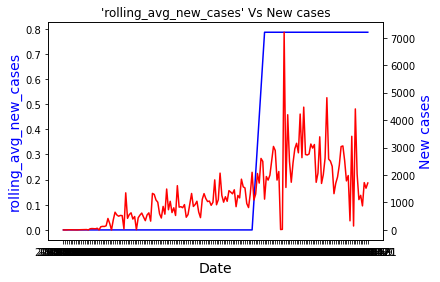

In [122]:
fig,ax = plt.subplots()
# make a plot
ax.plot(los_angeles_county.Date, los_angeles_county['rolling_avg_new_cases'], color="blue")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("rolling_avg_new_cases",color="blue",fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(los_angeles_county.Date, los_angeles_county["New cases"],color="red")
ax2.set_ylabel("New cases",color="blue",fontsize=14)
plt.title("'rolling_avg_new_cases' Vs New cases")

plt.show()

In [123]:
suffolk_county = CA_combined_data[CA_combined_data['County Name'] == 'Santa Clara County']

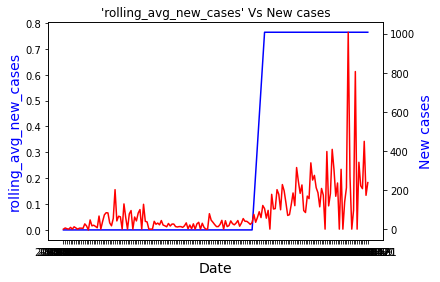

In [124]:
fig,ax = plt.subplots()
# make a plot
ax.plot(suffolk_county.Date, suffolk_county['rolling_avg_new_cases'], color="blue")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("rolling_avg_new_cases",color="blue",fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(suffolk_county.Date, suffolk_county["New cases"],color="red")
ax2.set_ylabel("New cases",color="blue",fontsize=14)
plt.title("'rolling_avg_new_cases' Vs New cases")

plt.show()

## Rolling window to compare every 2 weeks with next 2 weeks

In [125]:
CA_combined_data = CA_combined_data.sort_values(by=['Date'])
CA_combined_data.head()

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases,population
0,2020-03-01,6001,Alameda County,6.0,9.0,15.0,1.0,4.0,0.0,-7.65,3.684,58,2261.547725,0,0.0,0,0.0,1671329.0
5240,2020-03-01,6067,Sacramento County,11.0,4.0,26.0,1.0,2.0,-1.0,-4.63,3.773,53,1608.950489,0,0.0,0,0.0,1552058.0
5412,2020-03-01,6069,San Benito County,2.0,-1.0,-7.0,0.0,0.0,0.0,10.40,3.876,33,45.227585,0,0.0,0,0.0,62808.0
5584,2020-03-01,6071,San Bernardino County,5.0,-2.0,-22.0,2.0,-1.0,0.0,10.34,4.508,57,108.694796,0,0.0,0,0.0,2180085.0
5756,2020-03-01,6073,San Diego County,2.0,-1.0,-20.0,-4.0,2.0,0.0,-4.99,4.555,59,793.587741,0,0.0,0,0.0,3338330.0


In [126]:
CA_combined_data[CA_combined_data['fips_x'] == 6037]

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases,population
2924,2020-03-01,6037,Los Angeles County,4.0,3.0,-5.0,-3.0,1.0,0.0,-4.36,3.996,60,2473.978284,0,0.000,0,0.000,10039107.0
2925,2020-03-02,6037,Los Angeles County,5.0,5.0,8.0,1.0,4.0,-1.0,7.51,6.502,98,2473.978284,0,0.000,0,0.000,10039107.0
2926,2020-03-03,6037,Los Angeles County,8.0,7.0,32.0,2.0,3.0,-1.0,17.24,6.591,99,2473.978284,0,0.000,0,0.000,10039107.0
2927,2020-03-04,6037,Los Angeles County,4.0,6.0,9.0,-1.0,2.0,0.0,13.82,6.595,100,2473.978284,0,0.000,6,0.000,10039107.0
2928,2020-03-05,6037,Los Angeles County,4.0,7.0,9.0,0.0,2.0,0.0,22.17,7.008,106,2473.978284,0,0.000,4,0.000,10039107.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3091,2020-08-17,6037,Los Angeles County,0.0,0.0,0.0,0.0,-42.0,13.0,1.14,1.472,22,2473.978284,1,0.786,1259,0.786,10039107.0
3092,2020-08-18,6037,Los Angeles County,0.0,0.0,0.0,0.0,-42.0,15.0,3.51,2.137,32,2473.978284,1,0.786,875,0.786,10039107.0
3093,2020-08-19,6037,Los Angeles County,0.0,0.0,0.0,0.0,-42.0,15.0,6.42,1.656,25,2473.978284,1,0.786,1722,0.786,10039107.0
3094,2020-08-20,6037,Los Angeles County,0.0,0.0,0.0,0.0,-42.0,15.0,8.13,2.227,33,2473.978284,1,0.786,1519,0.786,10039107.0


In [127]:
minDate = CA_combined_data['Date'].min()
print(minDate)

dateList = CA_combined_data['Date'].unique()

2020-03-01


In [128]:
import datetime

#dt_object = datetime.fromtimestamp(date)
day_name= ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']

day = datetime.datetime.strptime(minDate, '%Y-%m-%d').weekday()
if day == 6:
  day =0
elif day < 6:
  day += 1

print(day)

0


In [129]:
index = 0
count = 0
lst = []
while index < len(dateList):
  row = []
  j = 14 - day;
  # print(index,j)
  # print(dateList[index:index+j])
  weekRange = dateList[index:index+j]
  #print(weekRange)
  index = index+j 
  day = 0
  count +=1
  row.append(count)
  row.append(weekRange.min())
  row.append(weekRange.max())
  print(row)
  lst.append(row)
  


[1, '2020-03-01', '2020-03-14']
[2, '2020-03-15', '2020-03-28']
[3, '2020-03-29', '2020-04-11']
[4, '2020-04-12', '2020-04-26']
[5, '2020-04-27', '2020-05-10']
[6, '2020-05-11', '2020-05-24']
[7, '2020-05-25', '2020-06-08']
[8, '2020-06-09', '2020-06-22']
[9, '2020-06-23', '2020-07-06']
[10, '2020-07-07', '2020-07-20']
[11, '2020-07-21', '2020-08-03']
[12, '2020-08-04', '2020-08-17']
[13, '2020-08-18', '2020-08-21']


In [130]:
week_df = pd.DataFrame(lst,index=None,columns=['WeekNumber','startDate','endDate'])
week_df.head()

,WeekNumber,startDate,endDate
0,1,2020-03-01,2020-03-14
1,2,2020-03-15,2020-03-28
2,3,2020-03-29,2020-04-11
3,4,2020-04-12,2020-04-26
4,5,2020-04-27,2020-05-10


## Slice data for the week dataframe

In [131]:

average_newCases_df = pd.DataFrame(columns=['County Name',  'fips_x',  'average_per_week','startDate','endDate'])

for index, row in week_df.iterrows():
    startDate, endDate = row['startDate'], row['endDate']
    df_index = (CA_combined_data['Date'] >= startDate) & (CA_combined_data['Date'] <= endDate)
    df_weekData =  CA_combined_data.loc[df_index]
    df_base = (
      df_weekData
      .pipe(lambda x: x.assign(gains_pctg=x["rolling_avg_new_cases"]))
      .groupby(['County Name','fips_x'])
      .agg({"gains_pctg": "mean"})
      .reset_index()
      .rename(columns={"gains_pctg": "average_per_week"})
    )
    df_base['startDate'] = startDate
    df_base['endDate'] = endDate
  
    #print(startDate,endDate,df_base['average_per_week'])
    average_newCases_df = average_newCases_df.append(df_base)


In [132]:
average_newCases_df.shape

(701, 5)

In [133]:
average_newCases_df[average_newCases_df['fips_x'] == 6037]

,County Name,fips_x,average_per_week,startDate,endDate
17,Los Angeles County,6037,0.000000,2020-03-01,2020-03-14
17,Los Angeles County,6037,0.000000,2020-03-15,2020-03-28
17,Los Angeles County,6037,0.000000,2020-03-29,2020-04-11
17,Los Angeles County,6037,0.000000,2020-04-12,2020-04-26
17,Los Angeles County,6037,0.000000,2020-04-27,2020-05-10
17,Los Angeles County,6037,0.000000,2020-05-11,2020-05-24
17,Los Angeles County,6037,0.000000,2020-05-25,2020-06-08
17,Los Angeles County,6037,0.120306,2020-06-09,2020-06-22
17,Los Angeles County,6037,0.777980,2020-06-23,2020-07-06
17,Los Angeles County,6037,0.786000,2020-07-07,2020-07-20


## Verifying average per week data Eg., Los Angeles County

In [134]:
los_angeles_county[(los_angeles_county['Date'] >= '2020-03-01') & (los_angeles_county['Date'] <= '2020-03-14') ]['rolling_avg_new_cases']



2924    0.0
2925    0.0
2926    0.0
2927    0.0
2928    0.0
2929    0.0
2930    0.0
2931    0.0
2932    0.0
2933    0.0
2934    0.0
2935    0.0
2936    0.0
2937    0.0
Name: rolling_avg_new_cases, dtype: float64

In [135]:
average_newCases_df.head(10)

,County Name,fips_x,average_per_week,startDate,endDate
0,Alameda County,6001,0.0,2020-03-01,2020-03-14
1,Amador County,6005,0.0,2020-03-01,2020-03-14
2,Butte County,6007,0.0,2020-03-01,2020-03-14
3,Calaveras County,6009,0.0,2020-03-01,2020-03-14
4,Colusa County,6011,0.0,2020-03-01,2020-03-14
5,Contra Costa County,6013,0.0,2020-03-01,2020-03-14
6,Del Norte County,6015,0.0,2020-03-01,2020-03-14
7,El Dorado County,6017,0.0,2020-03-01,2020-03-14
8,Fresno County,6019,0.0,2020-03-01,2020-03-14
9,Glenn County,6021,0.0,2020-03-01,2020-03-14


## Finding the % growth or reduction in 'new cases' on every 2 week average

In [136]:
average_newCases_df_ = average_newCases_df.copy()

In [137]:
albany_avg_newCases = average_newCases_df[average_newCases_df['County Name'] == 'Los Angeles County']
albany_avg_newCases

,County Name,fips_x,average_per_week,startDate,endDate
17,Los Angeles County,6037,0.000000,2020-03-01,2020-03-14
17,Los Angeles County,6037,0.000000,2020-03-15,2020-03-28
17,Los Angeles County,6037,0.000000,2020-03-29,2020-04-11
17,Los Angeles County,6037,0.000000,2020-04-12,2020-04-26
17,Los Angeles County,6037,0.000000,2020-04-27,2020-05-10
17,Los Angeles County,6037,0.000000,2020-05-11,2020-05-24
17,Los Angeles County,6037,0.000000,2020-05-25,2020-06-08
17,Los Angeles County,6037,0.120306,2020-06-09,2020-06-22
17,Los Angeles County,6037,0.777980,2020-06-23,2020-07-06
17,Los Angeles County,6037,0.786000,2020-07-07,2020-07-20


In [138]:
# average_newCases_df = average_newCases_df.sort_values(by=['startDate','endDate'])

# print(average_newCases_df.shape)
# temp = average_newCases_df.groupby(['County Name','fips_x','startDate','endDate'])['average_per_week']
# temp = temp.sum().diff().reset_index()
# print("-------------")
# print(temp)
# print(temp.shape)

# average_newCases_df2 = average_newCases_df.merge(temp,on=['County Name','fips_x','startDate','endDate'])
# print(average_newCases_df2.shape)

In [139]:
average_newCases_df.head()

,County Name,fips_x,average_per_week,startDate,endDate
0,Alameda County,6001,0.0,2020-03-01,2020-03-14
1,Amador County,6005,0.0,2020-03-01,2020-03-14
2,Butte County,6007,0.0,2020-03-01,2020-03-14
3,Calaveras County,6009,0.0,2020-03-01,2020-03-14
4,Colusa County,6011,0.0,2020-03-01,2020-03-14


In [140]:
# average_newCases_df = average_newCases_df.sort_values(by=['startDate','endDate'])

# print(average_newCases_df.shape)
# temp = average_newCases_df.groupby(['County Name','fips_x','startDate','endDate'])['average_per_week']
# temp = temp.sum().diff().reset_index()
# print("-------------")
# print(temp)
# print(temp.shape)

# average_newCases_df2 = average_newCases_df.merge(temp,on=['County Name','fips_x','startDate','endDate'])
# print(average_newCases_df2.shape)

In [141]:
average_newCases_df2 = average_newCases_df.copy()

average_newCases_df2 = average_newCases_df2.reset_index(drop=True)
average_newCases_df2.head()

,County Name,fips_x,average_per_week,startDate,endDate
0,Alameda County,6001,0.0,2020-03-01,2020-03-14
1,Amador County,6005,0.0,2020-03-01,2020-03-14
2,Butte County,6007,0.0,2020-03-01,2020-03-14
3,Calaveras County,6009,0.0,2020-03-01,2020-03-14
4,Colusa County,6011,0.0,2020-03-01,2020-03-14


In [142]:
average_newCases_df2['diff_avg_x'] = average_newCases_df2.sort_values(['startDate','endDate']).groupby(['County Name', 'fips_x'])['average_per_week'].diff().fillna(0)

print(average_newCases_df2.shape)
average_newCases_df2.head()


(701, 6)


,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x
0,Alameda County,6001,0.0,2020-03-01,2020-03-14,0.0
1,Amador County,6005,0.0,2020-03-01,2020-03-14,0.0
2,Butte County,6007,0.0,2020-03-01,2020-03-14,0.0
3,Calaveras County,6009,0.0,2020-03-01,2020-03-14,0.0
4,Colusa County,6011,0.0,2020-03-01,2020-03-14,0.0


In [143]:
average_newCases_df2[average_newCases_df2['County Name'] == 'Santa Clara County']

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x
40,Santa Clara County,6085,0.000000,2020-03-01,2020-03-14,0.000000e+00
94,Santa Clara County,6085,0.000000,2020-03-15,2020-03-28,0.000000e+00
147,Santa Clara County,6085,0.000000,2020-03-29,2020-04-11,0.000000e+00
201,Santa Clara County,6085,0.000000,2020-04-12,2020-04-26,0.000000e+00
255,Santa Clara County,6085,0.000000,2020-04-27,2020-05-10,0.000000e+00
309,Santa Clara County,6085,0.000000,2020-05-11,2020-05-24,0.000000e+00
363,Santa Clara County,6085,0.000000,2020-05-25,2020-06-08,0.000000e+00
417,Santa Clara County,6085,0.116939,2020-06-09,2020-06-22,1.169388e-01
471,Santa Clara County,6085,0.756204,2020-06-23,2020-07-06,6.392653e-01
525,Santa Clara County,6085,0.764000,2020-07-07,2020-07-20,7.795918e-03


In [144]:
average_newCases_df2[average_newCases_df2['County Name'] == 'Alameda County']

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x
0,Alameda County,6001,0.000000,2020-03-01,2020-03-14,0.000000
54,Alameda County,6001,0.000000,2020-03-15,2020-03-28,0.000000
108,Alameda County,6001,0.000000,2020-03-29,2020-04-11,0.000000
161,Alameda County,6001,0.000000,2020-04-12,2020-04-26,0.000000
215,Alameda County,6001,0.000000,2020-04-27,2020-05-10,0.000000
269,Alameda County,6001,0.000000,2020-05-11,2020-05-24,0.000000
323,Alameda County,6001,0.000000,2020-05-25,2020-06-08,0.000000
377,Alameda County,6001,0.121684,2020-06-09,2020-06-22,0.121684
431,Alameda County,6001,0.786888,2020-06-23,2020-07-06,0.665204
485,Alameda County,6001,0.795000,2020-07-07,2020-07-20,0.008112


In [145]:
average_newCases_df2[average_newCases_df2['fips_x'] == 6037].head(5)

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x
17,Los Angeles County,6037,0.0,2020-03-01,2020-03-14,0.0
71,Los Angeles County,6037,0.0,2020-03-15,2020-03-28,0.0
125,Los Angeles County,6037,0.0,2020-03-29,2020-04-11,0.0
178,Los Angeles County,6037,0.0,2020-04-12,2020-04-26,0.0
232,Los Angeles County,6037,0.0,2020-04-27,2020-05-10,0.0


In [146]:
average_newCases_df2.head()

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x
0,Alameda County,6001,0.0,2020-03-01,2020-03-14,0.0
1,Amador County,6005,0.0,2020-03-01,2020-03-14,0.0
2,Butte County,6007,0.0,2020-03-01,2020-03-14,0.0
3,Calaveras County,6009,0.0,2020-03-01,2020-03-14,0.0
4,Colusa County,6011,0.0,2020-03-01,2020-03-14,0.0


In [147]:
average_newCases_df2 = average_newCases_df2.fillna(0)

In [148]:
average_newCases_df2.head()

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x
0,Alameda County,6001,0.0,2020-03-01,2020-03-14,0.0
1,Amador County,6005,0.0,2020-03-01,2020-03-14,0.0
2,Butte County,6007,0.0,2020-03-01,2020-03-14,0.0
3,Calaveras County,6009,0.0,2020-03-01,2020-03-14,0.0
4,Colusa County,6011,0.0,2020-03-01,2020-03-14,0.0


In [149]:
#not working
#average_newCases_df2['pct_change_newcases'] = average_newCases_df2.sort_values(['startDate','endDate']).groupby(['County Name', 'fips_x','startDate','endDate']).average_per_week_y.pct_change()

Shifting average_per_week_x	 column value for formula. Means previous row's value will be come to the current row.

In [150]:
average_newCases_df2['shift_avg_x'] = average_newCases_df2.sort_values(['startDate','endDate']).groupby(['County Name', 'fips_x'])['average_per_week'].shift()

In [151]:
average_newCases_df2.groupby(by=['County Name', 'fips_x','startDate','endDate']).sum()

average_per_week  ...  shift_avg_x
County Name    fips_x startDate  endDate                       ...             
Alameda County 6001   2020-03-01 2020-03-14          0.000000  ...     0.000000
                      2020-03-15 2020-03-28          0.000000  ...     0.000000
                      2020-03-29 2020-04-11          0.000000  ...     0.000000
                      2020-04-12 2020-04-26          0.000000  ...     0.000000
                      2020-04-27 2020-05-10          0.000000  ...     0.000000
...                                                       ...  ...          ...
Yuba County    6115   2020-06-23 2020-07-06          0.662173  ...     0.102398
                      2020-07-07 2020-07-20          0.669000  ...     0.662173
                      2020-07-21 2020-08-03          0.669000  ...     0.669000
                      2020-08-04 2020-08-17          0.669000  ...     0.669000
                      2020-08-18 2020-08-21          0.669000  ...     0.669000

[701 rows x 3 columns]

In [152]:
average_newCases_df2[average_newCases_df2['County Name'] == 'Los Angeles County']

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x,shift_avg_x
17,Los Angeles County,6037,0.000000,2020-03-01,2020-03-14,0.000000e+00,NaN
71,Los Angeles County,6037,0.000000,2020-03-15,2020-03-28,0.000000e+00,0.000000
125,Los Angeles County,6037,0.000000,2020-03-29,2020-04-11,0.000000e+00,0.000000
178,Los Angeles County,6037,0.000000,2020-04-12,2020-04-26,0.000000e+00,0.000000
232,Los Angeles County,6037,0.000000,2020-04-27,2020-05-10,0.000000e+00,0.000000
286,Los Angeles County,6037,0.000000,2020-05-11,2020-05-24,0.000000e+00,0.000000
340,Los Angeles County,6037,0.000000,2020-05-25,2020-06-08,0.000000e+00,0.000000
394,Los Angeles County,6037,0.120306,2020-06-09,2020-06-22,1.203061e-01,0.000000
448,Los Angeles County,6037,0.777980,2020-06-23,2020-07-06,6.576735e-01,0.120306
502,Los Angeles County,6037,0.786000,2020-07-07,2020-07-20,8.020408e-03,0.777980


In [153]:
average_newCases_df2['percent_newcases'] = average_newCases_df2.apply(lambda x: (x.diff_avg_x) / x.shift_avg_x if x.shift_avg_x > 0.0 else 0 , axis=1)


average_newCases_df2.tail()


,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x,shift_avg_x,percent_newcases
696,Tulare County,6107,0.685,2020-08-18,2020-08-21,1.110223e-16,0.685,1.620764e-16
697,Tuolumne County,6109,0.653,2020-08-18,2020-08-21,1.110223e-16,0.653,1.700188e-16
698,Ventura County,6111,0.777,2020-08-18,2020-08-21,1.110223e-16,0.777,1.428858e-16
699,Yolo County,6113,0.791,2020-08-18,2020-08-21,0.000000e+00,0.791,0.000000e+00
700,Yuba County,6115,0.669,2020-08-18,2020-08-21,1.110223e-16,0.669,1.659526e-16


In [154]:
average_newCases_df2[average_newCases_df2['County Name'] == 'Los Angeles County']

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x,shift_avg_x,percent_newcases
17,Los Angeles County,6037,0.000000,2020-03-01,2020-03-14,0.000000e+00,NaN,0.000000e+00
71,Los Angeles County,6037,0.000000,2020-03-15,2020-03-28,0.000000e+00,0.000000,0.000000e+00
125,Los Angeles County,6037,0.000000,2020-03-29,2020-04-11,0.000000e+00,0.000000,0.000000e+00
178,Los Angeles County,6037,0.000000,2020-04-12,2020-04-26,0.000000e+00,0.000000,0.000000e+00
232,Los Angeles County,6037,0.000000,2020-04-27,2020-05-10,0.000000e+00,0.000000,0.000000e+00
286,Los Angeles County,6037,0.000000,2020-05-11,2020-05-24,0.000000e+00,0.000000,0.000000e+00
340,Los Angeles County,6037,0.000000,2020-05-25,2020-06-08,0.000000e+00,0.000000,0.000000e+00
394,Los Angeles County,6037,0.120306,2020-06-09,2020-06-22,1.203061e-01,0.000000,0.000000e+00
448,Los Angeles County,6037,0.777980,2020-06-23,2020-07-06,6.576735e-01,0.120306,5.466667e+00
502,Los Angeles County,6037,0.786000,2020-07-07,2020-07-20,8.020408e-03,0.777980,1.030928e-02


# 1.2 Labeling data as per % change

## Validation

In [155]:
test_ca_combined = average_newCases_df2.copy()

In [156]:
test_ca_combined[(test_ca_combined['fips_x']== 6001) & (test_ca_combined['startDate']=='2020-08-18')]

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x,shift_avg_x,percent_newcases
647,Alameda County,6001,0.795,2020-08-18,2020-08-21,0.0,0.795,0.0


## Actual Work

In [157]:
average_newCases_df2.describe()

,fips_x,average_per_week,diff_avg_x,shift_avg_x,percent_newcases
count,701.000000,701.000000,7.010000e+02,647.000000,7.010000e+02
mean,6057.724679,0.286073,5.565335e-02,0.249651,4.295390e-01
std,32.987094,0.350164,1.627743e-01,0.338997,1.497501e+00
min,6001.000000,0.000000,-2.220446e-16,0.000000,-2.523234e-16
25%,6029.000000,0.000000,0.000000e+00,0.000000,0.000000e+00
50%,6059.000000,0.000000,0.000000e+00,0.000000,0.000000e+00
75%,6085.000000,0.685000,1.110223e-16,0.669000,0.000000e+00
max,6115.000000,0.889000,7.438571e-01,0.889000,1.073333e+01


In [158]:
los_angeles_county = average_newCases_df2[average_newCases_df2['County Name'] == 'Los Angeles County']

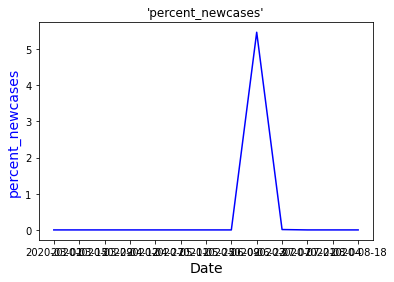

In [159]:
fig,ax = plt.subplots()
# make a plot
ax.plot(los_angeles_county.startDate, los_angeles_county['percent_newcases'], color="blue")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("percent_newcases",color="blue",fontsize=14)
# ax2=ax.twinx()
# make a plot with different y-axis using second axis object
# ax2.plot(los_angeles_county.startDate, los_angeles_county["percent_newcases"],color="red")
# ax2.set_ylabel("New cases",color="blue",fontsize=14)
plt.title("'percent_newcases'")

plt.show()

In [160]:
data = average_newCases_df2['percent_newcases'].to_list()

print(data)


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [161]:
average_newCases_df3 = average_newCases_df2.copy().reset_index(drop=True)

In [162]:
average_newCases_df3.head()

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x,shift_avg_x,percent_newcases
0,Alameda County,6001,0.0,2020-03-01,2020-03-14,0.0,NaN,0.0
1,Amador County,6005,0.0,2020-03-01,2020-03-14,0.0,NaN,0.0
2,Butte County,6007,0.0,2020-03-01,2020-03-14,0.0,NaN,0.0
3,Calaveras County,6009,0.0,2020-03-01,2020-03-14,0.0,NaN,0.0
4,Colusa County,6011,0.0,2020-03-01,2020-03-14,0.0,NaN,0.0


In [163]:
new_cases_list = average_newCases_df2['percent_newcases'].values

## Determining growth label for covid cases

#### Getting diff array

In [164]:
len(new_cases_list)

701

In [165]:
diffArr = np.diff(new_cases_list)
print(len(diffArr))
diffArr[0]

700


0.0

In [166]:
growth_values =[]
growth_values.append(0.0) # making first value as 0, as np.diff leaves first values as NA
print('growth_values : ',len(growth_values))
growth_values.extend(diffArr)
print('growth_values : ',len(growth_values))


growth_values :  1
growth_values :  701


In [167]:
len(growth_values)

701

In [168]:
average_newCases_df2['growth_per_day'] = growth_values

In [169]:
average_newCases_df2.dtypes

County Name          object
fips_x                int64
average_per_week    float64
startDate            object
endDate              object
diff_avg_x          float64
shift_avg_x         float64
percent_newcases    float64
growth_per_day      float64
dtype: object

### Checking mean, std dev and variance for growth data

In [170]:
stdDev = np.std(diffArr)
variance = np.var(diffArr)
mean = np.mean(diffArr)
min = np.min(diffArr)
max = np.max(diffArr)


print("min ",min)
print("max ",max)

print("mean ",mean)
print("std. deviation ",stdDev)
print("variance ",variance)

min  -5.456357388316149
max  5.466666666666666
mean  4.336808689942018e-19
std. deviation  0.4055787169294746
variance  0.16449409562615888


#### Getting positive cases

In [171]:
print('length diffArr: ',len(diffArr))

non_zero_pos_diff = []

for i in diffArr:
  if i > 0:
    non_zero_pos_diff.append(i)

print('non_zero_pos_diff length: ',len(non_zero_pos_diff))

length diffArr:  700
non_zero_pos_diff length:  77


In [172]:
stdDev = np.std(non_zero_pos_diff)
variance = np.var(non_zero_pos_diff)
mean = np.mean(non_zero_pos_diff)
min = np.min(non_zero_pos_diff)
max = np.max(non_zero_pos_diff)


print("min ",min)
print("max ",max)

print("mean ",mean)
print("std. deviation ",stdDev)
print("variance ",variance)

min  3.537345784081112e-18
max  5.466666666666666
mean  0.14047758512964761
std. deviation  0.8536375206133405
variance  0.7286970165988914


#### Getting negative cases

In [173]:
print('length diffArr: ',len(diffArr))

non_zero_neg_diff = []

for i in diffArr:
  if i < 0:
    non_zero_neg_diff.append(i)
print("non_zero_neg_diff length : ",len(non_zero_neg_diff))


length diffArr:  700
non_zero_neg_diff length :  72


In [174]:
stdDev = np.std(non_zero_neg_diff)
variance = np.var(non_zero_neg_diff)
mean = np.mean(non_zero_neg_diff)
min = np.min(non_zero_neg_diff)
max = np.max(non_zero_neg_diff)


print("min ",min)
print("max ",max)

print("mean ",mean)
print("std. deviation ",stdDev)
print("variance ",variance)

min  -5.456357388316149
max  -6.938893903907228e-18
mean  -0.15023297298587315
std. deviation  0.8810634848931068
variance  0.7762728644119858


### Trying natural breaks

In [175]:
!pip install jenkspy


In [176]:
import jenkspy

In [177]:
pos_breaks = jenkspy.jenks_breaks(non_zero_pos_diff, nb_class=2)
print(pos_breaks)
neg_breaks = jenkspy.jenks_breaks(non_zero_neg_diff, nb_class=2)
print(neg_breaks)

[3.537345784081112e-18, 0.08344072164948449, 5.466666666666666]
[-5.456357388316149, -5.26666666666667, -6.938893903907228e-18]


##### **Note**: 
From the positive and negative break, 
* [ -0.012359, 0.000374 ] - flat growth
* [ 0.000374, 21.813186 ] - mild growth
* [ 21.813186, 95.421053 ] - drastic growth
* [ -0.012359, -21.813186 ] - mild decrement
* [ -21.813186, -95.421053 ] - drastic decrement

In [178]:
# original range for CA combined data

'''
def determine_growth_label(x):
  if x >= -0.012359 and x <= 0.000374:
    return 'flat_growth'
  if x > 0.000374 and x <= 21.813186:
    return 'mild_growth'
  if x > 21.813186 and x <= 95.421053:
    return 'drastic_growth'
  if x >= -21.813186  and x <= -0.012359:
    return 'mild_decrement'
  if x >= -95.421053 and x < -21.813186:
    return 'drastic_decrement'
'''


"\ndef determine_growth_label(x):\n  if x >= -0.012359 and x <= 0.000374:\n    return 'flat_growth'\n  if x > 0.000374 and x <= 21.813186:\n    return 'mild_growth'\n  if x > 21.813186 and x <= 95.421053:\n    return 'drastic_growth'\n  if x >= -21.813186  and x <= -0.012359:\n    return 'mild_decrement'\n  if x >= -95.421053 and x < -21.813186:\n    return 'drastic_decrement'\n"

In [179]:
# temporarily using NY combined data range for CA
def determine_growth_label(x):
  if x >= -0.002109 and x <= 0.00011:
    return 'flat_growth'
  if x > 0.00011 and x <= 39.5:
    return 'mild_growth'
  if x > 39.5 and x <= 410.1818:
    return 'drastic_growth'
  if x >= -39.5  and x <= -0.0021:
    return 'mild_decrement'
  if x >= -410.18 and x < -39.5:
    return 'drastic_decrement'

In [180]:
average_newCases_df2['growth_label'] = average_newCases_df2['growth_per_day'].apply(lambda x: determine_growth_label(x) )

In [181]:
average_newCases_df2.head()

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x,shift_avg_x,percent_newcases,growth_per_day,growth_label
0,Alameda County,6001,0.0,2020-03-01,2020-03-14,0.0,NaN,0.0,0.0,flat_growth
1,Amador County,6005,0.0,2020-03-01,2020-03-14,0.0,NaN,0.0,0.0,flat_growth
2,Butte County,6007,0.0,2020-03-01,2020-03-14,0.0,NaN,0.0,0.0,flat_growth
3,Calaveras County,6009,0.0,2020-03-01,2020-03-14,0.0,NaN,0.0,0.0,flat_growth
4,Colusa County,6011,0.0,2020-03-01,2020-03-14,0.0,NaN,0.0,0.0,flat_growth


In [182]:
average_newCases_df2_growth0 = average_newCases_df2[average_newCases_df2['growth_label'] == 'drastic_decrement']
average_newCases_df2_growth1 = average_newCases_df2[average_newCases_df2['growth_label'] == 'drastic_growth']
average_newCases_df2_growth2 = average_newCases_df2[average_newCases_df2['growth_label'] == 'flat_growth']
average_newCases_df2_growth3 = average_newCases_df2[average_newCases_df2['growth_label'] == 'mild_decrement']
average_newCases_df2_growth4 = average_newCases_df2[average_newCases_df2['growth_label'] == 'mild_growth']

print(average_newCases_df2_growth0.shape)
print(average_newCases_df2_growth1.shape)
print(average_newCases_df2_growth2.shape)
print(average_newCases_df2_growth3.shape)
print(average_newCases_df2_growth4.shape)

(0, 10)
(0, 10)
(694, 10)
(4, 10)
(3, 10)


## Jenks Natural breaks 

In [183]:
breaks = jenkspy.jenks_breaks(average_newCases_df2['percent_newcases'], nb_class=3)
print(breaks)

[-2.523234146875355e-16, 0.09375000000000003, 5.4666666666666694, 10.733333333333338]


In [184]:
breaks = jenkspy.jenks_breaks(average_newCases_df2['percent_newcases'], nb_class=8)
print(breaks)

[-2.523234146875355e-16, 2.754895842742325e-16, 0.010309278350515535, 0.010309278350515542, 0.01030927835051564, 0.09375000000000003, 5.466666666666665, 5.4666666666666694, 10.733333333333338]


### Labeling criteria

We have applied "jenks Natural breaks' to label the county data as per 'percent change in cases'

From the natural break algorithm, we have splited the data as follows 

* -1.136 to 3.642 is **label 1** (least chance of spreading) 

* 3.642 to 13.625 is **label 2** (Below threshold but chances to reach super spread level)

* 13.625 to 410.181818 is **label 3** (Super spread week)

In [185]:
average_newCases_df2['labels'] = pd.cut(average_newCases_df2['percent_newcases'],
                        bins=breaks,
                        labels=['LessSpread','Spread', 'SuperSpread1','SuperSpread2','SuperSpread3','SuperSpread4','SuperSpread5','SuperSpread6'])

In [186]:
print('Number of records in LessSpread:',average_newCases_df2[average_newCases_df2['labels'] == 'LessSpread']['County Name'].count())
print('Number of records in Spread:',average_newCases_df2[average_newCases_df2['labels'] == 'Spread']['County Name'].count())
print('Number of records in SuperSpread:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread1']['County Name'].count())
print('Number of records in SuperSpread2:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread2']['County Name'].count())


print('Number of records in SuperSpread3:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread3']['County Name'].count())

print('Number of records in SuperSpread4:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread4']['County Name'].count())

print('Number of records in SuperSpread5:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread5']['County Name'].count())

print('Number of records in SuperSpread6:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread6']['County Name'].count())




Number of records in LessSpread: 592
Number of records in Spread: 43
Number of records in SuperSpread: 2
Number of records in SuperSpread2: 8
Number of records in SuperSpread3: 1
Number of records in SuperSpread4: 14
Number of records in SuperSpread5: 39
Number of records in SuperSpread6: 1


In [187]:
import jenkspy

breaks = jenkspy.jenks_breaks(average_newCases_df2['percent_newcases'], nb_class=4)
print(breaks)

[-2.523234146875355e-16, 0.01030927835051564, 0.09375000000000003, 5.4666666666666694, 10.733333333333338]


In [188]:
average_newCases_df2['labels'] = pd.cut(average_newCases_df2['percent_newcases'],
                        bins=breaks,
                        labels=['LessSpread','Spread', 'SuperSpread','SuperSpread2'])

In [189]:
print('Number of records in LessSpread:',average_newCases_df2[average_newCases_df2['labels'] == 'LessSpread']['County Name'].count())
print('Number of records in Spread:',average_newCases_df2[average_newCases_df2['labels'] == 'Spread']['County Name'].count())
print('Number of records in SuperSpread:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread']['County Name'].count())

print('Number of records in SuperSpread:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread2']['County Name'].count())

Number of records in LessSpread: 645
Number of records in Spread: 1
Number of records in SuperSpread: 53
Number of records in SuperSpread: 1


In [190]:
average_newCases_df2.head()

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x,shift_avg_x,percent_newcases,growth_per_day,growth_label,labels
0,Alameda County,6001,0.0,2020-03-01,2020-03-14,0.0,NaN,0.0,0.0,flat_growth,LessSpread
1,Amador County,6005,0.0,2020-03-01,2020-03-14,0.0,NaN,0.0,0.0,flat_growth,LessSpread
2,Butte County,6007,0.0,2020-03-01,2020-03-14,0.0,NaN,0.0,0.0,flat_growth,LessSpread
3,Calaveras County,6009,0.0,2020-03-01,2020-03-14,0.0,NaN,0.0,0.0,flat_growth,LessSpread
4,Colusa County,6011,0.0,2020-03-01,2020-03-14,0.0,NaN,0.0,0.0,flat_growth,LessSpread


# 1.3 Labeling data for CA combined

In [191]:
CA_combined_data.head(2)

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases,population
0,2020-03-01,6001,Alameda County,6.0,9.0,15.0,1.0,4.0,0.0,-7.65,3.684,58,2261.547725,0,0.0,0,0.0,1671329.0
5240,2020-03-01,6067,Sacramento County,11.0,4.0,26.0,1.0,2.0,-1.0,-4.63,3.773,53,1608.950489,0,0.0,0,0.0,1552058.0


In [192]:
CA_combined_data_ = CA_combined_data.copy()

In [193]:
CA_combined_data = CA_combined_data_.copy().reset_index(drop=True)

In [194]:
#average_newCases_df = pd.DataFrame(columns=['County Name',  'fips_x',  'average_per_week','startDate','endDate'])

for index, row in (average_newCases_df2.iterrows()):
    startDate, endDate = row['startDate'], row['endDate']
    fips = row['fips_x']
    #print(startDate,endDate,fips)
    df_index = (CA_combined_data['fips_x'] == row['fips_x']) & (CA_combined_data['Date'] >= startDate) & (CA_combined_data['Date'] <= endDate)
    df_weekData =  CA_combined_data.loc[df_index]
    #print(df_weekData)
    CA_combined_data.loc[df_index,'label'] = row['labels']
    CA_combined_data.loc[df_index,'growth_label'] = row['growth_label']




In [195]:
CA_combined_data.head()

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases,population,label,growth_label
0,2020-03-01,6001,Alameda County,6.0,9.0,15.0,1.0,4.0,0.0,-7.65,3.684,58,2261.547725,0,0.0,0,0.0,1671329.0,LessSpread,flat_growth
1,2020-03-01,6067,Sacramento County,11.0,4.0,26.0,1.0,2.0,-1.0,-4.63,3.773,53,1608.950489,0,0.0,0,0.0,1552058.0,LessSpread,flat_growth
2,2020-03-01,6069,San Benito County,2.0,-1.0,-7.0,0.0,0.0,0.0,10.40,3.876,33,45.227585,0,0.0,0,0.0,62808.0,LessSpread,flat_growth
3,2020-03-01,6071,San Bernardino County,5.0,-2.0,-22.0,2.0,-1.0,0.0,10.34,4.508,57,108.694796,0,0.0,0,0.0,2180085.0,LessSpread,flat_growth
4,2020-03-01,6073,San Diego County,2.0,-1.0,-20.0,-4.0,2.0,0.0,-4.99,4.555,59,793.587741,0,0.0,0,0.0,3338330.0,LessSpread,flat_growth


In [196]:
CA_combined_data[CA_combined_data['label'] == 'SuperSpread2'].sort_values(by=['fips_x','Date']).count()

Date                     10
fips_x                   10
County Name              10
retail and recreation    10
grocery and pharmacy     10
parks                    10
transit stations         10
workplaces               10
residential              10
driving                  10
m50                      10
m50_index                10
population_density       10
mask_rule_active         10
mask_wearing_percent     10
New cases                10
rolling_avg_new_cases    10
population               10
label                    10
growth_label             10
dtype: int64

In [197]:
CA_combined_data.shape

(9196, 20)

In [198]:
CA_combined_data['label'] = CA_combined_data['label'].apply(lambda x: x if x != 'SuperSpread2' else 'SuperSpread')

In [199]:
CA_combined_data.dtypes

Date                      object
fips_x                     int64
County Name               object
retail and recreation    float64
grocery and pharmacy     float64
parks                    float64
transit stations         float64
workplaces               float64
residential              float64
driving                  float64
m50                      float64
m50_index                  int64
population_density       float64
mask_rule_active           int64
mask_wearing_percent     float64
New cases                  int64
rolling_avg_new_cases    float64
population               float64
label                     object
growth_label              object
dtype: object

In [200]:
CA_combined_data[CA_combined_data['label'] == 'LessSpread'].count()

Date                     8429
fips_x                   8429
County Name              8429
retail and recreation    8429
grocery and pharmacy     8429
parks                    8429
transit stations         8429
workplaces               8429
residential              8429
driving                  8429
m50                      8429
m50_index                8429
population_density       8429
mask_rule_active         8429
mask_wearing_percent     8429
New cases                8429
rolling_avg_new_cases    8429
population               8429
label                    8429
growth_label             8429
dtype: int64

In [201]:
CA_combined_data[CA_combined_data['growth_label'] == 'flat_growth'].count()

Date                     9105
fips_x                   9105
County Name              9105
retail and recreation    9105
grocery and pharmacy     9105
parks                    9105
transit stations         9105
workplaces               9105
residential              9105
driving                  9105
m50                      9105
m50_index                9105
population_density       9105
mask_rule_active         9105
mask_wearing_percent     9105
New cases                9105
rolling_avg_new_cases    9105
population               9105
label                    9101
growth_label             9105
dtype: int64

## Computing New Cases per 1k Population

Formula: 'New Cases/1k population' = (New Cases * 1000)/population

In [202]:
CA_combined_data['New Cases/1k population'] = CA_combined_data['New cases']*1000/ CA_combined_data['population']
CA_combined_data.tail(2)

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases,population,label,growth_label,New Cases/1k population
9194,2020-08-21,6035,Lassen County,0.0,0.0,0.0,0.0,-24.0,0.0,222.10,3.061,100,6.732391,1,0.482,0,0.482,30573.0,LessSpread,flat_growth,0.000000
9195,2020-08-21,6115,Yuba County,0.0,0.0,0.0,0.0,-33.0,10.0,84.31,5.820,61,124.506204,1,0.669,8,0.669,78668.0,LessSpread,flat_growth,0.101693


In [203]:
new_cases_10k_list = CA_combined_data['New Cases/1k population'].values

In [204]:
diffArr = np.diff(new_cases_10k_list)
print(len(diffArr))
diffArr[0]

growth_values =[]
growth_values.append(0.0) # making first value as 0, as np.diff leaves first values as NA
print('growth_values : ',len(growth_values))
growth_values.extend(diffArr)
print('growth_values : ',len(growth_values))

9195
growth_values :  1
growth_values :  9196


In [205]:
stdDev = np.std(diffArr)
variance = np.var(diffArr)
mean = np.mean(diffArr)
min = np.min(diffArr)
max = np.max(diffArr)


print("min ",min)
print("max ",max)

print("mean ",mean)
print("std. deviation ",stdDev)
print("variance ",variance)

min  -3.8230281887128026
max  3.960127989407119
mean  1.1059618449245788e-05
std. deviation  0.24857264730595022
variance  0.061788360988688326


## Getting positive cases

In [206]:
print('length diffArr: ',len(diffArr))

non_zero_pos_diff = []

for i in diffArr:
  if i > 0:
    non_zero_pos_diff.append(i)

print('non_zero_pos_diff length: ',len(non_zero_pos_diff))


stdDev = np.std(non_zero_pos_diff)
variance = np.var(non_zero_pos_diff)
mean = np.mean(non_zero_pos_diff)
min = np.min(non_zero_pos_diff)
max = np.max(non_zero_pos_diff)


print("min ",min)
print("max ",max)

print("mean ",mean)
print("std. deviation ",stdDev)
print("variance ",variance)

length diffArr:  9195
non_zero_pos_diff length:  3594
min  5.2680092775606036e-05
max  3.960127989407119
mean  0.12711974477163043
std. deviation  0.25049541298583716
variance  0.06274795192694511


## Getting negative cases


In [207]:
non_zero_neg_diff = []

for i in diffArr:
  if i < 0:
    non_zero_neg_diff.append(i)
print("non_zero_neg_diff length : ",len(non_zero_neg_diff))

stdDev = np.std(non_zero_neg_diff)
variance = np.var(non_zero_neg_diff)
mean = np.mean(non_zero_neg_diff)
min = np.min(non_zero_neg_diff)
max = np.max(non_zero_neg_diff)


print("min ",min)
print("max ",max)

print("mean ",mean)
print("std. deviation ",stdDev)
print("variance ",variance)


non_zero_neg_diff length :  3583
min  -3.8230281887128026
max  -8.310897482368892e-06
mean  -0.12748162699346885
std. deviation  0.2513272017941629
variance  0.0631653623616839


In [208]:
CA_combined_data.head()

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases,population,label,growth_label,New Cases/1k population
0,2020-03-01,6001,Alameda County,6.0,9.0,15.0,1.0,4.0,0.0,-7.65,3.684,58,2261.547725,0,0.0,0,0.0,1671329.0,LessSpread,flat_growth,0.0
1,2020-03-01,6067,Sacramento County,11.0,4.0,26.0,1.0,2.0,-1.0,-4.63,3.773,53,1608.950489,0,0.0,0,0.0,1552058.0,LessSpread,flat_growth,0.0
2,2020-03-01,6069,San Benito County,2.0,-1.0,-7.0,0.0,0.0,0.0,10.40,3.876,33,45.227585,0,0.0,0,0.0,62808.0,LessSpread,flat_growth,0.0
3,2020-03-01,6071,San Bernardino County,5.0,-2.0,-22.0,2.0,-1.0,0.0,10.34,4.508,57,108.694796,0,0.0,0,0.0,2180085.0,LessSpread,flat_growth,0.0
4,2020-03-01,6073,San Diego County,2.0,-1.0,-20.0,-4.0,2.0,0.0,-4.99,4.555,59,793.587741,0,0.0,0,0.0,3338330.0,LessSpread,flat_growth,0.0


## Applying natural breaks

In [209]:
pos_breaks = jenkspy.jenks_breaks(non_zero_pos_diff, nb_class=2)
print(pos_breaks)
neg_breaks = jenkspy.jenks_breaks(non_zero_neg_diff, nb_class=2)
print(neg_breaks)

print(' ****** breaks *******')
breaks = pos_breaks + neg_breaks
breaks.sort()
breaks

[5.2680092775606036e-05, 0.5928496690142417, 3.960127989407119]
[-3.8230281887128026, -0.5659584931410302, -8.310897482368892e-06]
 ****** breaks *******


[-3.8230281887128026,
 -0.5659584931410302,
 -8.310897482368892e-06,
 5.2680092775606036e-05,
 0.5928496690142417,
 3.960127989407119]

## New Labeling

In [210]:
'''
****** breaks *******
[-4.811795376206633,
 -1.0427002573115152,
 -9.454894623110721e-06,
 1.1045153360346449e-05,
 0.835960519245697,
 4.811795376206633

 def determine_growth_label_1k(x):
  x = round(x,4)
  if x > 0.83596 and x <= 4.8118:
    return 'drastic_growth'
  if x > 0.00001 and x <= 0.8360:
    return 'mild_growth'
  if x >= -0.00000945 and x <= 0.00001:
    return 'flat_growth'
  if x >= -1.0427 and x < -0.00000945:
    return 'mild_decrement'
  if x >= -4.8118  and x <= -1.0427:
    return 'drastic_decrement'
'''

"\n****** breaks *******\n[-4.811795376206633,\n -1.0427002573115152,\n -9.454894623110721e-06,\n 1.1045153360346449e-05,\n 0.835960519245697,\n 4.811795376206633\n\n def determine_growth_label_1k(x):\n  x = round(x,4)\n  if x > 0.83596 and x <= 4.8118:\n    return 'drastic_growth'\n  if x > 0.00001 and x <= 0.8360:\n    return 'mild_growth'\n  if x >= -0.00000945 and x <= 0.00001:\n    return 'flat_growth'\n  if x >= -1.0427 and x < -0.00000945:\n    return 'mild_decrement'\n  if x >= -4.8118  and x <= -1.0427:\n    return 'drastic_decrement'\n"

In [211]:
#[5.2680092775606036e-05, 0.5928496690142417, 3.960127989407119]
#[-3.8230281887128026, -0.5659584931410302, -8.310897482368892e-06]
def determine_growth_label_1k(x):
  if x >= -0.00000831 and x <= 0.0000526:
    return 'flat_growth'
  if x > 0.0000526 and x <= 0.59285:
    return 'mild_growth'
  if x > 0.59285 and x <= 3.96013:
    return 'drastic_growth'
  if x >= -0.56595  and x <= -0.00000831:
    return 'mild_decrement'
  if x >= -3.96013 and x < -0.56595:
    return 'drastic_decrement'

In [212]:
CA_combined_data['growth_label_1k'] = CA_combined_data['New Cases/1k population'].apply(lambda x: determine_growth_label_1k(x) )
CA_combined_data.head(4)

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases,population,label,growth_label,New Cases/1k population,growth_label_1k
0,2020-03-01,6001,Alameda County,6.0,9.0,15.0,1.0,4.0,0.0,-7.65,3.684,58,2261.547725,0,0.0,0,0.0,1671329.0,LessSpread,flat_growth,0.0,flat_growth
1,2020-03-01,6067,Sacramento County,11.0,4.0,26.0,1.0,2.0,-1.0,-4.63,3.773,53,1608.950489,0,0.0,0,0.0,1552058.0,LessSpread,flat_growth,0.0,flat_growth
2,2020-03-01,6069,San Benito County,2.0,-1.0,-7.0,0.0,0.0,0.0,10.40,3.876,33,45.227585,0,0.0,0,0.0,62808.0,LessSpread,flat_growth,0.0,flat_growth
3,2020-03-01,6071,San Bernardino County,5.0,-2.0,-22.0,2.0,-1.0,0.0,10.34,4.508,57,108.694796,0,0.0,0,0.0,2180085.0,LessSpread,flat_growth,0.0,flat_growth


### Export Combined labeled Data

In [215]:
CA_combined_data_test = CA_combined_data.copy()
CA_combined_data_test.shape

(9196, 22)

In [ ]:
CA_combined_data_growth0 = CA_combined_data[CA_combined_data['growth_label'] == 'drastic_decrement']
CA_combined_data_growth1 = CA_combined_data[CA_combined_data['growth_label'] == 'drastic_growth']
CA_combined_data_growth2 = CA_combined_data[CA_combined_data['growth_label'] == 'flat_growth']
CA_combined_data_growth3 = CA_combined_data[CA_combined_data['growth_label'] == 'mild_decrement']
CA_combined_data_growth4 = CA_combined_data[CA_combined_data['growth_label'] == 'mild_growth']

print(CA_combined_data_growth0.shape)
print(CA_combined_data_growth1.shape)
print(CA_combined_data_growth2.shape)
print(CA_combined_data_growth3.shape)
print(CA_combined_data_growth4.shape)

In [ ]:
from datetime import datetime
location = '/content/drive/Shared drives/CMPE 295- Master Project/Covid19-data/'
filename = 'CA_labeledData_'+datetime.now().strftime("%b%d")+'.csv' #%Y%m%d
print(filename)
CA_combined_data.to_csv(location+filename,index=False)

In [ ]:
average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread']

## Kernal Density Estimation

In [ ]:
%matplotlib inline

from numpy import array, linspace
from sklearn.neighbors.kde import KernelDensity
from matplotlib.pyplot import plot

a = array(data).reshape(-1, 1)
kde = KernelDensity(kernel='gaussian', bandwidth=3).fit(a)
s = linspace(0,50)
e = kde.score_samples(s.reshape(-1,1))
plot(s, e)

In [ ]:


from scipy.signal import argrelextrema
mi, ma = argrelextrema(e, np.less)[0], argrelextrema(e, np.greater)[0]
print("Minima:", s[mi])
print("Maxima:", s[ma])

In [ ]:
lower_range = s[mi][0]
upper_range = s[mi][1]

lower_range

In [ ]:
print(a[a < mi[0]], a[(a >= mi[0]) * (a <= mi[1])], a[a >= mi[1]])


[-1.1363636363636362, 39.5, 213.91325695581014, 410.1818181818182]

Minima: [19.3877551  33.67346939]
Maxima: [24.48979592 39.79591837]*italicized text*

In [ ]:
plot(s[:mi[0]+1], e[:mi[0]+1], 'r',
     s[mi[0]:mi[1]+1], e[mi[0]:mi[1]+1], 'g',
     s[mi[1]:], e[mi[1]:], 'b',
     s[ma], e[ma], 'go',
     s[mi], e[mi], 'ro')

print(a[a < mi[0]], a[(a >= mi[0]) * (a <= mi[1])], a[a >= mi[1]])


## Labeling Data with Kernal density results

In [ ]:
average_newCases_df3.head()

In [ ]:
print(lower_range, upper_range)

In [ ]:
average_newCases_df3['label'] = average_newCases_df3['percent_newcases'].apply(lambda x: 'lessSpread' if x < lower_range  else 'SuperSpread')


In [ ]:
average_newCases_df3['label'] = average_newCases_df3['percent_newcases'].apply(lambda x: 'lessSpread' if x < lower_range else ('Spread' if (x >= lower_range and x <= upper_range) else 'SuperSpread'))



#converter = lambda x : x*2 if x < 10 else (x*3 if x < 20 else x)



In [ ]:
average_newCases_df3[average_newCases_df3['label'] == 'lessSpread'].count()

In [ ]:
average_newCases_df3[average_newCases_df3['label'] == 'Spread'].count()

In [ ]:
average_newCases_df3[average_newCases_df3['label'] == 'SuperSpread'].count()

In [ ]:
average_newCases_df3.head()

# 2.1 Loading CA - Social Distancing Inertia Maryland Data

In [ ]:
CA_combined_sd_inertia_data = pd.read_csv('/content/drive/Shared drives/CMPE 295- Master Project/Covid19-data/CA_socialDistancingInertiaData_Sep25.csv',low_memory=False)
CA_combined_sd_inertia_data.head()

In [ ]:
CA_combined_sd_inertia_data.FIPS.unique()

## Computing rolling average

In [ ]:
CA_combined_sd_inertia_data.columns

In [ ]:
#new case column nume = 5
CA_combined_sd_inertia_data.iloc[:,5]

removing comuns: 
'Confirmed', 'Deaths', 'New deaths','#days: decreasing ILI cases', '#days: decreasing COVID cases', 'New cases/1000 people', 'Imported COVID cases' ,'COVID death rate',  'Active cases/1000 people',

In [ ]:
df = pd.DataFrame(columns=['Date', 'Province_State', 'FIPS',  'New cases',
        'mask_rule_active', 'CTFIPS', 'CTNAME', 'STFIPS',
       'Social distancing index', '% staying home', 'Trips/person',
       '% out-of-county trips', '% out-of-state trips', 'Miles/person',
       'Work trips/person', 'Non-work trips/person', 'New COVID cases',
       'Population', '% change in consumption', 'date', 'Transit mode share',
       '% people older than 60', 'Median income', '% African Americans',
       '% Hispanic Americans', '% Male', 'Population density',
       'Employment density', '# hot spots/1000 people',
       'Hospital beds/1000 people', 'ICUs/1000 people',
       '# contact tracing workers/1000 people',
       '# contact tracing workers/1000 people rank',
       '% people older than 60 rank', 'COVID exposure/1000 people',
        'Unemployment claims/1000 people',
       'Unemployment rate', '% working from home', 'Cumulative inflation rate',
        '% hospital bed utilization',
       'Testing capacity', 'Tests done/1000 people', '% ICU utilization',
       'Ventilator shortage'])


In [ ]:
CA_counties = CA_combined_sd_inertia_data['CTNAME'].unique()

for county in CA_counties:
  county_data = CA_combined_sd_inertia_data[CA_combined_sd_inertia_data['CTNAME'] == county]
  #print(county_data.iloc[:,15])
  county_data['rolling_avg_new_cases'] = county_data.iloc[:,5].rolling(window=7).mean()
  df = df.append(county_data)

df.head()

In [ ]:
print(df.shape)
CA_combined_sd_inertia_data.shape

In [ ]:
CA_combined_sd_inertia_data = df.copy()
CA_combined_sd_inertia_data

In [ ]:
CA_combined_sd_inertia_data.head(3)

## clean data - fill NA 

In [ ]:
CA_combined_sd_inertia_data = CA_combined_sd_inertia_data.fillna(0)
CA_combined_sd_inertia_data.head(4)

In [ ]:
CA_combined_sd_inertia_data['CTNAME'].unique()

## verifying Rolling average with visualizations

In [ ]:
los_angeles_county = CA_combined_sd_inertia_data[CA_combined_sd_inertia_data['CTNAME'] == 'Los Angeles County']
print(los_angeles_county.shape)
los_angeles_county.head()

In [ ]:
fig,ax = plt.subplots()
# make a plot
ax.plot(los_angeles_county.Date, los_angeles_county['rolling_avg_new_cases'], color="blue")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("rolling_avg_new_cases",color="blue",fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(los_angeles_county.Date, los_angeles_county["New cases"],color="red")
ax2.set_ylabel("New cases",color="blue",fontsize=14)
plt.title("'rolling_avg_new_cases' Vs New cases")

plt.show()

In [ ]:
suffolk_county = CA_combined_sd_inertia_data[CA_combined_sd_inertia_data['CTNAME'] == 'Santa Clara County']

In [ ]:
fig,ax = plt.subplots()
# make a plot
ax.plot(suffolk_county.Date, suffolk_county['rolling_avg_new_cases'], color="blue")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("rolling_avg_new_cases",color="blue",fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(suffolk_county.Date, suffolk_county["New cases"],color="red")
ax2.set_ylabel("New cases",color="blue",fontsize=14)
plt.title("'rolling_avg_new_cases' Vs New cases")

plt.show()

## Rolling window to compare every 2 weeks with next 2 weeks

In [ ]:
CA_combined_sd_inertia_data = CA_combined_sd_inertia_data.sort_values(by=['Date'])
CA_combined_sd_inertia_data.head()

In [ ]:
CA_combined_sd_inertia_data[CA_combined_sd_inertia_data['FIPS'] == 6037]

In [ ]:
minDate = CA_combined_sd_inertia_data['Date'].min()
print(minDate)

dateList = CA_combined_sd_inertia_data['Date'].unique()

In [ ]:
import datetime

#dt_object = datetime.fromtimestamp(date)
day_name= ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']

day = datetime.datetime.strptime(minDate, '%Y-%m-%d').weekday()
if day == 6:
  day =0
elif day < 6:
  day += 1

print(day)

In [ ]:
index = 0
count = 0
lst = []
while index < len(dateList):
  row = []
  j = 14 - day;
  # print(index,j)
  # print(dateList[index:index+j])
  weekRange = dateList[index:index+j]
  #print(weekRange)
  index = index+j 
  day = 0
  count +=1
  row.append(count)
  row.append(weekRange.min())
  row.append(weekRange.max())
  print(row)
  lst.append(row)
  


[1, '2020-03-01', '2020-03-14']
[2, '2020-03-15', '2020-03-28']
[3, '2020-03-29', '2020-04-11']
[4, '2020-04-12', '2020-04-26']
[5, '2020-04-27', '2020-05-10']
[6, '2020-05-11', '2020-05-24']
[7, '2020-05-25', '2020-06-08']
[8, '2020-06-09', '2020-06-22']
[9, '2020-06-23', '2020-07-06']
[10, '2020-07-07', '2020-07-20']
[11, '2020-07-21', '2020-08-03']
[12, '2020-08-04', '2020-08-17']
[13, '2020-08-18', '2020-08-21']

In [ ]:
week_df = pd.DataFrame(lst,index=None,columns=['WeekNumber','startDate','endDate'])
week_df.head()

## Slice data for the week dataframe

In [ ]:

average_newCases_df = pd.DataFrame(columns=['CTNAME',  'FIPS',  'average_per_week','startDate','endDate'])

for index, row in week_df.iterrows():
    startDate, endDate = row['startDate'], row['endDate']
    df_index = (CA_combined_sd_inertia_data['Date'] >= startDate) & (CA_combined_sd_inertia_data['Date'] <= endDate)
    df_weekData =  CA_combined_sd_inertia_data.loc[df_index]
    df_base = (
      df_weekData
      .pipe(lambda x: x.assign(gains_pctg=x["rolling_avg_new_cases"]))
      .groupby(['CTNAME','FIPS'])
      .agg({"gains_pctg": "mean"})
      .reset_index()
      .rename(columns={"gains_pctg": "average_per_week"})
    )
    df_base['startDate'] = startDate
    df_base['endDate'] = endDate
  
    #print(startDate,endDate,df_base['average_per_week'])
    average_newCases_df = average_newCases_df.append(df_base)


In [ ]:
average_newCases_df.shape

In [ ]:
average_newCases_df[average_newCases_df['FIPS'] == 6037]

## Verifying average per week data Eg., Los Angeles County

In [ ]:
los_angeles_county[(los_angeles_county['Date'] >= '2020-03-01') & (los_angeles_county['Date'] <= '2020-03-14') ]['rolling_avg_new_cases']



In [ ]:
average_newCases_df.head(10)

## Finding the % growth or reduction in 'new cases' on every 2 week average

In [ ]:
average_newCases_df_ = average_newCases_df.copy()

In [ ]:
albany_avg_newCases = average_newCases_df[average_newCases_df['CTNAME'] == 'Los Angeles County']
albany_avg_newCases

In [ ]:
average_newCases_df.head()

In [ ]:
average_newCases_df2 = pd.DataFrame()
average_newCases_df2 = average_newCases_df.copy()

average_newCases_df2 = average_newCases_df2.reset_index(drop=True)
average_newCases_df2.head()

In [ ]:
average_newCases_df2['diff_avg_x'] = average_newCases_df2.sort_values(['startDate','endDate']).groupby(['CTNAME', 'FIPS'])['average_per_week'].diff().fillna(0)

print(average_newCases_df2.shape)
average_newCases_df2.head()


In [ ]:
average_newCases_df2[average_newCases_df2['CTNAME'] == 'Santa Clara County']

In [ ]:
average_newCases_df2[average_newCases_df2['CTNAME'] == 'Alameda County']

In [ ]:
average_newCases_df2[average_newCases_df2['FIPS'] == 6037].head(5)

In [ ]:
average_newCases_df2.head()

In [ ]:
average_newCases_df2 = average_newCases_df2.fillna(0)

In [ ]:
average_newCases_df2.head()

Shifting average_per_week_x	 column value for formula. Means previous row's value will be come to the current row.

In [ ]:
average_newCases_df2['shift_avg_x'] = average_newCases_df2.sort_values(['startDate','endDate']).groupby(['CTNAME', 'FIPS'])['average_per_week'].shift()

In [ ]:
average_newCases_df2.groupby(by=['CTNAME', 'FIPS','startDate','endDate']).sum()

In [ ]:
average_newCases_df2[average_newCases_df2['CTNAME'] == 'Los Angeles County']

In [ ]:
average_newCases_df2['percent_newcases'] = average_newCases_df2.apply(lambda x: (x.diff_avg_x) / x.shift_avg_x if x.shift_avg_x > 0.0 else 0 , axis=1)


average_newCases_df2.tail()


In [ ]:
average_newCases_df2[average_newCases_df2['CTNAME'] == 'Santa Clara County']

# 2.2 Labeling data as per % change

## Validation

In [ ]:
average_newCases_df2.head(3)

In [ ]:
average_newCases_df2[(average_newCases_df2['FIPS']== 6001) & (average_newCases_df2['startDate']=='2020-08-02')]

In [ ]:
test_ca_combined[(test_ca_combined['fips_x']== 6001) & (test_ca_combined['startDate']=='2020-08-04')]

## Actual Work

In [ ]:
average_newCases_df2.describe()

In [ ]:
los_angeles_county = average_newCases_df2[average_newCases_df2['CTNAME'] == 'Los Angeles County']

In [ ]:
fig,ax = plt.subplots()
# make a plot
ax.plot(los_angeles_county.startDate, los_angeles_county['percent_newcases'], color="blue")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("percent_newcases",color="blue",fontsize=14)
# ax2=ax.twinx()
# make a plot with different y-axis using second axis object
# ax2.plot(los_angeles_county.startDate, los_angeles_county["percent_newcases"],color="red")
# ax2.set_ylabel("New cases",color="blue",fontsize=14)
plt.title("'percent_newcases'")

plt.show()

In [ ]:
data = average_newCases_df2['percent_newcases'].to_list()

print(data)


In [ ]:
average_newCases_df3 = average_newCases_df2.copy().reset_index(drop=True)

## Determining growth label

In [ ]:
new_cases_list = average_newCases_df2['percent_newcases'].values
diffArr = np.diff(new_cases_list)
print(len(diffArr))
diffArr[0]

In [ ]:
growth_values =[]
growth_values.append(0.0) # making first value as 0, as np.diff leaves first values as NA

print('growth_values : ',len(growth_values))
growth_values.extend(diffArr)
print('growth_values : ',len(growth_values))

In [ ]:
average_newCases_df2['growth_per_day'] = growth_values


### Checking mean, std dev and variance for growth data


In [ ]:
stdDev = np.std(diffArr)
variance = np.var(diffArr)
mean = np.mean(diffArr)
min = np.min(diffArr)
max = np.max(diffArr)


print("min ",min)
print("max ",max)

print("mean ",mean)
print("std. deviation ",stdDev)
print("variance ",variance)

### Getting positive cases

In [ ]:
print('length diffArr: ',len(diffArr))

non_zero_pos_diff = []

for i in diffArr:
  if i > 0:
    non_zero_pos_diff.append(i)

print('non_zero_pos_diff length: ',len(non_zero_pos_diff))


In [ ]:
stdDev = np.std(non_zero_pos_diff)
variance = np.var(non_zero_pos_diff)
mean = np.mean(non_zero_pos_diff)
min = np.min(non_zero_pos_diff)
max = np.max(non_zero_pos_diff)


print("min ",min)
print("max ",max)

print("mean ",mean)
print("std. deviation ",stdDev)
print("variance ",variance)


### Getting negative cases

In [ ]:
print('length diffArr: ',len(diffArr))

non_zero_neg_diff = []

for i in diffArr:
  if i < 0:
    non_zero_neg_diff.append(i)
print("non_zero_neg_diff length : ",len(non_zero_neg_diff))


In [ ]:
stdDev = np.std(non_zero_neg_diff)
variance = np.var(non_zero_neg_diff)
mean = np.mean(non_zero_neg_diff)
min = np.min(non_zero_neg_diff)
max = np.max(non_zero_neg_diff)


print("min ",min)
print("max ",max)

print("mean ",mean)
print("std. deviation ",stdDev)
print("variance ",variance)

### Applying Jenks Natural break

In [ ]:

pos_breaks = jenkspy.jenks_breaks(non_zero_pos_diff, nb_class=2)
print(pos_breaks)
neg_breaks = jenkspy.jenks_breaks(non_zero_neg_diff, nb_class=2)
print(neg_breaks)

#### **Note**: 

From the positive and negative break, 
* [ -0.009978 , 0.001377 ] - flat growth
* [ 0.001377 , 157.486111 ] - mild growth
* [ 157.486111 , 377.00 ] - drastic growth
* [ -0.009978 , -157.486111 ] - mild decrement
* [ -157.486111, -377.00 ] - drastic decrement

In [ ]:
#original range for CA -inertia data
'''
def determine_growth_label_inertia(x):
  if x >= -0.009978 and x <= 0.001377:
    return 'flat_growth'
  if x > 0.001377 and x <= 157.486111:
    return 'mild_growth'
  if x > 157.486111 and x <= 377.00:
    return 'drastic_growth'
  if x >= -157.486111  and x <= -0.009978:
    return 'mild_decrement'
  if x >= -377.00 and x < -157.486111:
    return 'drastic_decrement'
'''

In [ ]:
# temporarily using same label range of combined data for inertia data

'''
def determine_growth_label_inertia(x):
  if x >= -0.012359 and x <= 0.000374:
    return 'flat_growth'
  if x > 0.000374 and x <= 21.813186:
    return 'mild_growth'
  if x > 21.813186 and x <= 95.421053:
    return 'drastic_growth'
  if x >= -21.813186  and x <= -0.012359:
    return 'mild_decrement'
  if x >= -95.421053 and x < -21.813186:
    return 'drastic_decrement'
'''

In [ ]:
# temporarily using NY combined data range for CA
def determine_growth_label_inertia(x):
  if x >= -0.002109 and x <= 0.00011:
    return 'flat_growth'
  if x > 0.00011 and x <= 39.5:
    return 'mild_growth'
  if x > 39.5 and x <= 410.1818:
    return 'drastic_growth'
  if x >= -39.5  and x <= -0.0021:
    return 'mild_decrement'
  if x >= -410.18 and x < -39.5:
    return 'drastic_decrement'

In [ ]:
average_newCases_df2['growth_label'] = average_newCases_df2['growth_per_day'].apply(lambda x: determine_growth_label_inertia(x) )

In [ ]:
average_newCases_df2.head(3)

In [ ]:
average_newCases_df2_growth0 = average_newCases_df2[average_newCases_df2['growth_label'] == 'drastic_decrement']
average_newCases_df2_growth1 = average_newCases_df2[average_newCases_df2['growth_label'] == 'drastic_growth']
average_newCases_df2_growth2 = average_newCases_df2[average_newCases_df2['growth_label'] == 'flat_growth']
average_newCases_df2_growth3 = average_newCases_df2[average_newCases_df2['growth_label'] == 'mild_decrement']
average_newCases_df2_growth4 = average_newCases_df2[average_newCases_df2['growth_label'] == 'mild_growth']

print(average_newCases_df2_growth0.shape)
print(average_newCases_df2_growth1.shape)
print(average_newCases_df2_growth2.shape)
print(average_newCases_df2_growth3.shape)
print(average_newCases_df2_growth4.shape)

## Jenks Natural breaks 

In [ ]:
!pip install jenkspy


In [ ]:
import jenkspy

breaks = jenkspy.jenks_breaks(average_newCases_df2['percent_newcases'], nb_class=3)
print(breaks)

### Labeling criteria

We have applied "jenks Natural breaks' to label the county data as per 'percent change in cases'

From the natural break algorithm, we have splited the data as follows 

* -1.136 to 3.642 is **label 1** (least chance of spreading) 

* 3.642 to 13.625 is **label 2** (Below threshold but chances to reach super spread level)

* 13.625 to 410.181818 is **label 3** (Super spread week)

4 class labeling

In [ ]:
import jenkspy

breaks = jenkspy.jenks_breaks(average_newCases_df2['percent_newcases'], nb_class=4)
print(breaks)

In [ ]:
average_newCases_df2['labels'] = pd.cut(average_newCases_df2['percent_newcases'],
                        bins=breaks,
                        labels=['LessSpread','Spread', 'SuperSpread','SuperSpread2'])

In [ ]:
print('Number of records in LessSpread:',average_newCases_df2[average_newCases_df2['labels'] == 'LessSpread']['CTNAME'].count())
print('Number of records in Spread:',average_newCases_df2[average_newCases_df2['labels'] == 'Spread']['CTNAME'].count())
print('Number of records in SuperSpread:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread']['CTNAME'].count())

print('Number of records in SuperSpread:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread2']['CTNAME'].count())

8 class labeling

In [ ]:
breaks = jenkspy.jenks_breaks(average_newCases_df2['percent_newcases'], nb_class=8)
print(breaks)

In [ ]:
average_newCases_df2['labels'] = pd.cut(average_newCases_df2['percent_newcases'],
                        bins=breaks,
                        labels=['LessSpread','Spread', 'SuperSpread1','SuperSpread2','SuperSpread3','SuperSpread4','SuperSpread5','SuperSpread6'])

In [ ]:
print('Number of records in LessSpread:',average_newCases_df2[average_newCases_df2['labels'] == 'LessSpread']['CTNAME'].count())
print('Number of records in Spread:',average_newCases_df2[average_newCases_df2['labels'] == 'Spread']['CTNAME'].count())
print('Number of records in SuperSpread:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread1']['CTNAME'].count())
print('Number of records in SuperSpread2:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread2']['CTNAME'].count())
print('Number of records in SuperSpread3:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread3']['CTNAME'].count())
print('Number of records in SuperSpread4:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread4']['CTNAME'].count())
print('Number of records in SuperSpread5:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread5']['CTNAME'].count())
print('Number of records in SuperSpread6:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread6']['CTNAME'].count())

In [ ]:
average_newCases_df2.head()

# 2.3 Labeling data for CA -Maryland Social Distancing Inertia combined

In [ ]:
CA_combined_sd_inertia_data.head(2)

In [ ]:
CA_combined_sd_inertia_data_ = CA_combined_sd_inertia_data.copy()

In [ ]:
CA_combined_sd_inertia_data = CA_combined_sd_inertia_data_.copy().reset_index(drop=True)

In [ ]:
#average_newCases_df = pd.DataFrame(columns=['County Name',  'fips_x',  'average_per_week','startDate','endDate'])

for index, row in tqdm(average_newCases_df2.iterrows()):
    startDate, endDate = row['startDate'], row['endDate']
    fips = row['FIPS']
    #print(startDate,endDate,fips)
    df_index = (CA_combined_sd_inertia_data['FIPS'] == row['FIPS']) & (CA_combined_sd_inertia_data['Date'] >= startDate) & (CA_combined_sd_inertia_data['Date'] <= endDate)
    df_weekData =  CA_combined_sd_inertia_data.loc[df_index]
    #print(df_weekData)
    CA_combined_sd_inertia_data.loc[df_index,'label'] = row['labels']
    CA_combined_sd_inertia_data.loc[df_index,'growth_label'] = row['growth_label']




In [ ]:
CA_combined_sd_inertia_data.head(5)

In [ ]:
CA_combined_sd_inertia_data[CA_combined_sd_inertia_data['label'] == 'SuperSpread2'].sort_values(by=['FIPS','Date']).count()

In [ ]:
CA_combined_sd_inertia_data.shape

In [ ]:
CA_combined_sd_inertia_data['label'] = CA_combined_sd_inertia_data['label'].apply(lambda x: x if x != 'SuperSpread2' else 'SuperSpread')

## Computing growth label per 1k population

In [ ]:
newcases_1k_inertia = CA_combined_sd_inertia_data['New cases/1000 people'].values

In [ ]:
diffArr = np.diff(newcases_1k_inertia)
print(len(diffArr))
diffArr[0]

growth_values =[]
growth_values.append(0.0) # making first value as 0, as np.diff leaves first values as NA
print('growth_values : ',len(growth_values))
growth_values.extend(diffArr)
print('growth_values : ',len(growth_values))

## Determining mean,stddev, variance

In [ ]:
stdDev = np.std(diffArr)
variance = np.var(diffArr)
mean = np.mean(diffArr)
min = np.min(diffArr)
max = np.max(diffArr)


print("min ",min)
print("max ",max)

print("mean ",mean)
print("std. deviation ",stdDev)
print("variance ",variance)



## Getting positive cases

In [ ]:
print('length diffArr: ',len(diffArr))

non_zero_pos_diff = []

for i in diffArr:
  if i > 0:
    non_zero_pos_diff.append(i)

print('non_zero_pos_diff length: ',len(non_zero_pos_diff))


stdDev = np.std(non_zero_pos_diff)
variance = np.var(non_zero_pos_diff)
mean = np.mean(non_zero_pos_diff)
min = np.min(non_zero_pos_diff)
max = np.max(non_zero_pos_diff)


print("min ",min)
print("max ",max)

print("mean ",mean)
print("std. deviation ",stdDev)
print("variance ",variance)


## Getting negative cases

In [ ]:
non_zero_neg_diff = []

for i in diffArr:
  if i < 0:
    non_zero_neg_diff.append(i)
print("non_zero_neg_diff length : ",len(non_zero_neg_diff))

stdDev = np.std(non_zero_neg_diff)
variance = np.var(non_zero_neg_diff)
mean = np.mean(non_zero_neg_diff)
min = np.min(non_zero_neg_diff)
max = np.max(non_zero_neg_diff)


print("min ",min)
print("max ",max)

print("mean ",mean)
print("std. deviation ",stdDev)
print("variance ",variance)


## Applying natural breaks

In [ ]:
pos_breaks = jenkspy.jenks_breaks(non_zero_pos_diff, nb_class=2)
print(pos_breaks)
neg_breaks = jenkspy.jenks_breaks(non_zero_neg_diff, nb_class=2)
print(neg_breaks)


## New Labeling

In [ ]:

def determine_growth_label_inertia1k(x):
  if x >= -0.000009 and x <= 0.00009:
    return 'flat_growth'
  if x > 0.00009 and x <= 0.3248:
    return 'mild_growth'
  if x > 0.3248 and x <= 2.1234:
    return 'drastic_growth'
  if x >= -0.3404  and x <= -0.000009:
    return 'mild_decrement'
  if x >= -2.1359 and x < -0.3404:
    return 'drastic_decrement'

In [ ]:
CA_combined_sd_inertia_data['growth_label_1k'] = CA_combined_sd_inertia_data['New cases/1000 people'].apply(lambda x: determine_growth_label_inertia1k(x) )

In [ ]:
CA_combined_sd_inertia_data['growth_label_1k'].unique()
CA_combined_data['growth_label_1k'].unique()

In [ ]:
CA_combined_sd_inertia_data_growth0 = CA_combined_sd_inertia_data[CA_combined_sd_inertia_data['growth_label'] == 'drastic_decrement']
CA_combined_sd_inertia_data_growth1 = CA_combined_sd_inertia_data[CA_combined_sd_inertia_data['growth_label'] == 'drastic_growth']
CA_combined_sd_inertia_data_growth2 = CA_combined_sd_inertia_data[CA_combined_sd_inertia_data['growth_label'] == 'flat_growth']
CA_combined_sd_inertia_data_growth3 = CA_combined_sd_inertia_data[CA_combined_sd_inertia_data['growth_label'] == 'mild_decrement']
CA_combined_sd_inertia_data_growth4 = CA_combined_sd_inertia_data[CA_combined_sd_inertia_data['growth_label'] == 'mild_growth']

print(CA_combined_sd_inertia_data_growth0.shape)
print(CA_combined_sd_inertia_data_growth1.shape)
print(CA_combined_sd_inertia_data_growth2.shape)
print(CA_combined_sd_inertia_data_growth3.shape)
print(CA_combined_sd_inertia_data_growth4.shape)


### Export Labeled Maryland Inertia Data

In [ ]:
from datetime import datetime
location = '/content/drive/Shared drives/CMPE 295- Master Project/Covid19-data/'
filename = 'CA_sd_inertia_labeledData_'+datetime.now().strftime("%b%d")+'.csv' #%Y%m%d
print(filename)
CA_combined_sd_inertia_data.to_csv(location+filename,index=False)

In [ ]:
average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread']

## Kernal Density Estimation

In [ ]:
%matplotlib inline

from numpy import array, linspace
from sklearn.neighbors.kde import KernelDensity
from matplotlib.pyplot import plot

a = array(data).reshape(-1, 1)
kde = KernelDensity(kernel='gaussian', bandwidth=3).fit(a)
s = linspace(0,50)
e = kde.score_samples(s.reshape(-1,1))
plot(s, e)

In [ ]:


from scipy.signal import argrelextrema
mi, ma = argrelextrema(e, np.less)[0], argrelextrema(e, np.greater)[0]
print("Minima:", s[mi])
print("Maxima:", s[ma])

In [ ]:
lower_range = s[mi][0]
upper_range = s[mi][1]

lower_range

In [ ]:
print(a[a < mi[0]], a[(a >= mi[0]) * (a <= mi[1])], a[a >= mi[1]])


[-1.1363636363636362, 39.5, 213.91325695581014, 410.1818181818182]

Minima: [19.3877551  33.67346939]
Maxima: [24.48979592 39.79591837]*italicized text*

In [ ]:
plot(s[:mi[0]+1], e[:mi[0]+1], 'r',
     s[mi[0]:mi[1]+1], e[mi[0]:mi[1]+1], 'g',
     s[mi[1]:], e[mi[1]:], 'b',
     s[ma], e[ma], 'go',
     s[mi], e[mi], 'ro')

print(a[a < mi[0]], a[(a >= mi[0]) * (a <= mi[1])], a[a >= mi[1]])


## Labeling Data with Kernal density results

In [ ]:
average_newCases_df3.head()

In [ ]:
print(lower_range, upper_range)

In [ ]:
average_newCases_df3['label'] = average_newCases_df3['percent_newcases'].apply(lambda x: 'lessSpread' if x < lower_range  else 'SuperSpread')


In [ ]:
average_newCases_df3['label'] = average_newCases_df3['percent_newcases'].apply(lambda x: 'lessSpread' if x < lower_range else ('Spread' if (x >= lower_range and x <= upper_range) else 'SuperSpread'))



#converter = lambda x : x*2 if x < 10 else (x*3 if x < 20 else x)



In [ ]:
average_newCases_df3[average_newCases_df3['label'] == 'lessSpread'].count()

In [ ]:
average_newCases_df3[average_newCases_df3['label'] == 'Spread'].count()

In [ ]:
average_newCases_df3[average_newCases_df3['label'] == 'SuperSpread'].count()

In [ ]:
average_newCases_df3[average_newCases_df3['growth_label'] == 'SuperSpread'].count()

In [ ]:
average_newCases_df3.head()

# Scaling -Test

In [216]:
CA_combined_data_test.head(3)

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases,population,label,growth_label,New Cases/1k population,growth_label_1k
0,2020-03-01,6001,Alameda County,6.0,9.0,15.0,1.0,4.0,0.0,-7.65,3.684,58,2261.547725,0,0.0,0,0.0,1671329.0,LessSpread,flat_growth,0.0,flat_growth
1,2020-03-01,6067,Sacramento County,11.0,4.0,26.0,1.0,2.0,-1.0,-4.63,3.773,53,1608.950489,0,0.0,0,0.0,1552058.0,LessSpread,flat_growth,0.0,flat_growth
2,2020-03-01,6069,San Benito County,2.0,-1.0,-7.0,0.0,0.0,0.0,10.40,3.876,33,45.227585,0,0.0,0,0.0,62808.0,LessSpread,flat_growth,0.0,flat_growth


## New Cases = Greater than 2000

In [255]:
CA_combined_data_test_greaterthan2000 = CA_combined_data_test[(CA_combined_data_test['New cases'] > 2000 ) & (CA_combined_data_test['County Name']== 'Los Angeles County')]

In [256]:
CA_combined_data_test_greaterthan2000.sort_values(by='Date', ascending=True)


,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases,population,label,growth_label,New Cases/1k population,growth_label_1k
4711,2020-05-30,6037,Los Angeles County,-45.0,-12.0,-20.0,-39.0,-21.0,13.0,-12.42,0.644,9,2473.978284,0,0.000,2068,0.000000,10039107.0,LessSpread,flat_growth,0.205994,mild_growth
5701,2020-06-17,6037,Los Angeles County,-31.0,-10.0,-1.0,-37.0,-40.0,15.0,-5.60,2.701,40,2473.978284,0,0.000,2098,0.000000,10039107.0,LessSpread,flat_growth,0.208983,mild_growth
5832,2020-06-20,6037,Los Angeles County,-33.0,-4.0,-16.0,-34.0,-18.0,8.0,2.85,2.712,41,2473.978284,1,0.786,2054,0.336857,10039107.0,LessSpread,flat_growth,0.204600,mild_growth
5939,2020-06-22,6037,Los Angeles County,-31.0,-16.0,-4.0,-39.0,-41.0,14.0,-7.23,2.271,34,2473.978284,1,0.786,2603,0.561429,10039107.0,LessSpread,flat_growth,0.259286,mild_growth
6008,2020-06-23,6037,Los Angeles County,-30.0,-12.0,-2.0,-38.0,-41.0,15.0,-4.37,2.696,40,2473.978284,1,0.786,2495,0.673714,10039107.0,SuperSpread,flat_growth,0.248528,mild_growth
6286,2020-06-28,6037,Los Angeles County,-34.0,-15.0,-9.0,-38.0,-18.0,8.0,-16.22,1.199,18,2473.978284,1,0.786,2533,0.786000,10039107.0,SuperSpread,flat_growth,0.252313,mild_growth
6325,2020-06-29,6037,Los Angeles County,-28.0,-14.0,-5.0,-39.0,-39.0,14.0,-6.11,2.101,31,2473.978284,1,0.786,3040,0.786000,10039107.0,SuperSpread,flat_growth,0.302816,mild_growth
6370,2020-06-30,6037,Los Angeles County,-27.0,-11.0,-4.0,-39.0,-40.0,14.0,-2.06,3.019,45,2473.978284,1,0.786,2892,0.786000,10039107.0,SuperSpread,flat_growth,0.288073,mild_growth
6467,2020-07-02,6037,Los Angeles County,-25.0,-3.0,-3.0,-36.0,-42.0,14.0,7.05,3.032,45,2473.978284,1,0.786,2127,0.786000,10039107.0,SuperSpread,flat_growth,0.211871,mild_growth
6666,2020-07-05,6037,Los Angeles County,-40.0,-21.0,-24.0,-43.0,-25.0,9.0,-21.24,0.577,8,2473.978284,1,0.786,7198,0.786000,10039107.0,SuperSpread,flat_growth,0.716996,drastic_growth


In [230]:
#commenting this section and taking more value, otherwise neg_breaks is not working

#date_list = ['2020-08-15','2020-08-14','2020-08-12','2020-08-08','2020-08-07','2020-08-06','2020-08-05','2020-08-01']
#CA_combined_data_test_greaterthan2000 = CA_combined_data_test_greaterthan2000[CA_combined_data_test_greaterthan2000.Date.isin(date_list)]

In [231]:
CA_combined_data_test_greaterthan2000

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases,population,label,growth_label,New Cases/1k population,growth_label_1k
8093,2020-08-01,6037,Los Angeles County,-35.0,-7.0,-14.0,-35.0,-22.0,9.0,12.13,1.429,21,2473.978284,1,0.786,2316,0.786,10039107.0,LessSpread,flat_growth,0.230698,mild_growth
8296,2020-08-05,6037,Los Angeles County,-29.0,-11.0,0.0,-39.0,-42.0,14.0,4.58,2.307,34,2473.978284,1,0.786,2360,0.786,10039107.0,LessSpread,flat_growth,0.235081,mild_growth
8337,2020-08-06,6037,Los Angeles County,-30.0,-11.0,-1.0,-39.0,-42.0,15.0,7.23,1.934,29,2473.978284,1,0.786,3035,0.786,10039107.0,LessSpread,flat_growth,0.302318,mild_growth
8429,2020-08-07,6037,Los Angeles County,-31.0,-10.0,-2.0,-38.0,-41.0,15.0,21.07,2.654,40,2473.978284,1,0.786,3058,0.786,10039107.0,LessSpread,flat_growth,0.304609,mild_growth
8460,2020-08-08,6037,Los Angeles County,-34.0,-9.0,-10.0,-35.0,-22.0,9.0,13.19,1.879,28,2473.978284,1,0.786,2520,0.786,10039107.0,LessSpread,flat_growth,0.251018,mild_growth
8667,2020-08-12,6037,Los Angeles County,-30.0,-13.0,-1.0,-40.0,-42.0,14.0,8.05,2.064,31,2473.978284,1,0.786,3409,0.786,10039107.0,LessSpread,flat_growth,0.339572,mild_growth
8794,2020-08-14,6037,Los Angeles County,-32.0,-11.0,-8.0,-40.0,-41.0,14.0,25.15,2.504,37,2473.978284,1,0.786,4406,0.786,10039107.0,LessSpread,flat_growth,0.438884,mild_growth
8861,2020-08-15,6037,Los Angeles County,-35.0,-10.0,-18.0,-37.0,-24.0,9.0,16.28,1.944,29,2473.978284,1,0.786,2036,0.786,10039107.0,LessSpread,flat_growth,0.202807,mild_growth


### Growth based on 'New Cases'

In [257]:
new_cases_10k_list_test = CA_combined_data_test_greaterthan2000['New cases'].values
new_cases_10k_list_test

array([2068, 2098, 2054, 2603, 2495, 2533, 3040, 2892, 2127, 7198, 4194,
       2492, 2447, 2955, 3155, 2808, 4219, 2631, 4471, 2746, 2728, 2765,
       3128, 2980, 3109, 2067, 3390, 2011, 2614, 4814, 2580, 2505, 2316,
       2360, 3035, 3058, 2520, 3409, 4406, 2036])

In [258]:
diffArr = np.diff(new_cases_10k_list_test)
print(len(diffArr))
print(diffArr)
diffArr[0]


## checked manually; diffArr is working perfectly and taking difference between consecutive arrays

39
[   30   -44   549  -108    38   507  -148  -765  5071 -3004 -1702   -45
   508   200  -347  1411 -1588  1840 -1725   -18    37   363  -148   129
 -1042  1323 -1379   603  2200 -2234   -75  -189    44   675    23  -538
   889   997 -2370]


30

In [259]:
growth_values =[]
growth_values.append(0.0) # making first value as 0, as np.diff leaves first values as NA
print('growth_values : ',len(growth_values))
growth_values.extend(diffArr)
print('growth_values : ',len(growth_values))

growth_values :  1
growth_values :  40


In [260]:
stdDev = np.std(diffArr)
variance = np.var(diffArr)
mean = np.mean(diffArr)
min = np.min(diffArr)
max = np.max(diffArr)


print("min ",min)
print("max ",max)

print("mean ",mean)
print("std. deviation ",stdDev)
print("variance ",variance)

min  -3004
max  5071
mean  -0.8205128205128205
std. deviation  1371.9344544370665
variance  1882204.1472715314


### Getting positive cases

In [261]:
print('length diffArr: ',len(diffArr))

non_zero_pos_diff = []

for i in diffArr:
  if i > 0:
    non_zero_pos_diff.append(i)

print('non_zero_pos_diff length: ',len(non_zero_pos_diff))


stdDev = np.std(non_zero_pos_diff)
variance = np.var(non_zero_pos_diff)
mean = np.mean(non_zero_pos_diff)
min = np.min(non_zero_pos_diff)
max = np.max(non_zero_pos_diff)


print("min ",min)
print("max ",max)

print("mean ",mean)
print("std. deviation ",stdDev)
print("variance ",variance)
#diff_array =[   44   675    23  -538   889   997 -2370]

length diffArr:  39
non_zero_pos_diff length:  20
min  23
max  5071
mean  871.85
std. deviation  1142.237027722355
variance  1304705.4275


### Getting negative cases


In [262]:
non_zero_neg_diff = []

for i in diffArr:
  if i < 0:
    non_zero_neg_diff.append(i)
print("non_zero_neg_diff length : ",len(non_zero_neg_diff))

stdDev = np.std(non_zero_neg_diff)
variance = np.var(non_zero_neg_diff)
mean = np.mean(non_zero_neg_diff)
min = np.min(non_zero_neg_diff)
max = np.max(non_zero_neg_diff)


print("min ",min)
print("max ",max)

print("mean ",mean)
print("std. deviation ",stdDev)
print("variance ",variance)

#diff_array =[   44   675    23  -538   889   997 -2370]

non_zero_neg_diff length :  19
min  -3004
max  -18
mean  -919.421052631579
std. deviation  919.0402497221862
variance  844634.9806094184


In [263]:
CA_combined_data_test_greaterthan2000.head()

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases,population,label,growth_label,New Cases/1k population,growth_label_1k
4711,2020-05-30,6037,Los Angeles County,-45.0,-12.0,-20.0,-39.0,-21.0,13.0,-12.42,0.644,9,2473.978284,0,0.000,2068,0.000000,10039107.0,LessSpread,flat_growth,0.205994,mild_growth
5701,2020-06-17,6037,Los Angeles County,-31.0,-10.0,-1.0,-37.0,-40.0,15.0,-5.60,2.701,40,2473.978284,0,0.000,2098,0.000000,10039107.0,LessSpread,flat_growth,0.208983,mild_growth
5832,2020-06-20,6037,Los Angeles County,-33.0,-4.0,-16.0,-34.0,-18.0,8.0,2.85,2.712,41,2473.978284,1,0.786,2054,0.336857,10039107.0,LessSpread,flat_growth,0.204600,mild_growth
5939,2020-06-22,6037,Los Angeles County,-31.0,-16.0,-4.0,-39.0,-41.0,14.0,-7.23,2.271,34,2473.978284,1,0.786,2603,0.561429,10039107.0,LessSpread,flat_growth,0.259286,mild_growth
6008,2020-06-23,6037,Los Angeles County,-30.0,-12.0,-2.0,-38.0,-41.0,15.0,-4.37,2.696,40,2473.978284,1,0.786,2495,0.673714,10039107.0,SuperSpread,flat_growth,0.248528,mild_growth


### Applying natural breaks (Getting error here for neg_breaks; need more neg values)

In [265]:
pos_breaks = jenkspy.jenks_breaks(non_zero_pos_diff, nb_class=2)
print(pos_breaks)

### getting error here: "ValueError: Number of class have to be an integer greater than 2 and smaller than the number of values to use" 
neg_breaks = jenkspy.jenks_breaks(non_zero_neg_diff, nb_class=2)
print(neg_breaks)

print(' ****** breaks *******')
breaks = pos_breaks + neg_breaks
breaks.sort()
breaks

[23.0, 2200.0, 5071.0]
[-3004.0, -1379.0, -18.0]
 ****** breaks *******


[-3004.0, -1379.0, -18.0, 23.0, 2200.0, 5071.0]

### New Labeling

In [ ]:
#[5.2680092775606036e-05, 0.5928496690142417, 3.960127989407119]
#[-3.8230281887128026, -0.5659584931410302, -8.310897482368892e-06]

#[23.0, 2200.0, 5071.0]
#[-3004.0, -1379.0, -18.0]
def determine_growth_label_test(x):
  if x >= -0.00000831 and x <= 0.0000526:
    return 'flat_growth'
  if x > 0.0000526 and x <= 0.59285:
    return 'mild_growth'
  if x > 0.59285 and x <= 3.96013:
    return 'drastic_growth'
  if x >= -0.56595  and x <= -0.00000831:
    return 'mild_decrement'
  if x >= -3.96013 and x < -0.56595:
    return 'drastic_decrement'

In [ ]:
CA_combined_data_test_greaterthan2000['growth_label_test'] = CA_combined_data_test_greaterthan2000['New cases'].apply(lambda x: determine_growth_label_test(x) )
CA_combined_data_test_greaterthan2000.head(4)

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases,population,label,growth_label,New Cases/1k population,growth_label_1k
0,2020-03-01,6001,Alameda County,6.0,9.0,15.0,1.0,4.0,0.0,-7.65,3.684,58,2261.547725,0,0.0,0,0.0,1671329.0,LessSpread,flat_growth,0.0,flat_growth
1,2020-03-01,6067,Sacramento County,11.0,4.0,26.0,1.0,2.0,-1.0,-4.63,3.773,53,1608.950489,0,0.0,0,0.0,1552058.0,LessSpread,flat_growth,0.0,flat_growth
2,2020-03-01,6069,San Benito County,2.0,-1.0,-7.0,0.0,0.0,0.0,10.40,3.876,33,45.227585,0,0.0,0,0.0,62808.0,LessSpread,flat_growth,0.0,flat_growth
3,2020-03-01,6071,San Bernardino County,5.0,-2.0,-22.0,2.0,-1.0,0.0,10.34,4.508,57,108.694796,0,0.0,0,0.0,2180085.0,LessSpread,flat_growth,0.0,flat_growth


### Export Combined labeled Data

In [ ]:
CA_combined_data_test_greaterthan2000_growth0 = CA_combined_data_test_greaterthan2000[CA_combined_data_test_greaterthan2000['growth_label'] == 'drastic_decrement']
CA_combined_data_test_greaterthan2000_growth1 = CA_combined_data_test_greaterthan2000[CA_combined_data_test_greaterthan2000['growth_label'] == 'drastic_growth']
CA_combined_data_test_greaterthan2000_growth2 = CA_combined_data_test_greaterthan2000[CA_combined_data_test_greaterthan2000['growth_label'] == 'flat_growth']
CA_combined_data_test_greaterthan2000_growth3 = CA_combined_data_test_greaterthan2000[CA_combined_data_test_greaterthan2000['growth_label'] == 'mild_decrement']
CA_combined_data_test_greaterthan2000_growth4 = CA_combined_data_test_greaterthan2000[CA_combined_data_test_greaterthan2000['growth_label'] == 'mild_growth']

print(CA_combined_data_test_greaterthan2000_growth0.shape)
print(CA_combined_data_test_greaterthan2000_growth1.shape)
print(CA_combined_data_test_greaterthan2000_growth2.shape)
print(CA_combined_data_test_greaterthan2000_growth3.shape)
print(CA_combined_data_test_greaterthan2000_growth4.shape)

## New Cases = Less than 50

In [266]:
CA_combined_data_test_lessthan50 = CA_combined_data_test[(CA_combined_data_test['New cases'] < 50 ) & (CA_combined_data_test['County Name']== 'Los Angeles County')]

In [267]:
CA_combined_data_test_lessthan50.sort_values(by='Date', ascending=True)


,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases,population,label,growth_label,New Cases/1k population,growth_label_1k
38,2020-03-01,6037,Los Angeles County,4.0,3.0,-5.0,-3.0,1.0,0.0,-4.36,3.996,60,2473.978284,0,0.000,0,0.000,10039107.0,LessSpread,flat_growth,0.000000,flat_growth
93,2020-03-02,6037,Los Angeles County,5.0,5.0,8.0,1.0,4.0,-1.0,7.51,6.502,98,2473.978284,0,0.000,0,0.000,10039107.0,LessSpread,flat_growth,0.000000,flat_growth
115,2020-03-03,6037,Los Angeles County,8.0,7.0,32.0,2.0,3.0,-1.0,17.24,6.591,99,2473.978284,0,0.000,0,0.000,10039107.0,LessSpread,flat_growth,0.000000,flat_growth
196,2020-03-04,6037,Los Angeles County,4.0,6.0,9.0,-1.0,2.0,0.0,13.82,6.595,100,2473.978284,0,0.000,6,0.000,10039107.0,LessSpread,flat_growth,0.000598,mild_growth
267,2020-03-05,6037,Los Angeles County,4.0,7.0,9.0,0.0,2.0,0.0,22.17,7.008,106,2473.978284,0,0.000,4,0.000,10039107.0,LessSpread,flat_growth,0.000398,mild_growth
288,2020-03-06,6037,Los Angeles County,3.0,6.0,7.0,-2.0,2.0,0.0,35.24,7.351,111,2473.978284,0,0.000,2,0.000,10039107.0,LessSpread,flat_growth,0.000199,mild_growth
333,2020-03-07,6037,Los Angeles County,1.0,6.0,3.0,-4.0,2.0,0.0,26.34,6.024,91,2473.978284,0,0.000,1,0.000,10039107.0,LessSpread,flat_growth,0.000100,mild_growth
414,2020-03-08,6037,Los Angeles County,3.0,4.0,16.0,-4.0,1.0,0.0,0.08,4.202,63,2473.978284,0,0.000,0,0.000,10039107.0,LessSpread,flat_growth,0.000000,flat_growth
466,2020-03-09,6037,Los Angeles County,3.0,7.0,6.0,-4.0,3.0,0.0,3.92,6.140,93,2473.978284,0,0.000,0,0.000,10039107.0,LessSpread,flat_growth,0.000000,flat_growth
484,2020-03-10,6037,Los Angeles County,-3.0,3.0,-29.0,-13.0,-2.0,3.0,4.27,6.178,93,2473.978284,0,0.000,6,0.000,10039107.0,LessSpread,flat_growth,0.000598,mild_growth


In [ ]:
#commenting this section and taking more value, otherwise neg_breaks is not working

#date_list = ['2020-08-15','2020-08-14','2020-08-12','2020-08-08','2020-08-07','2020-08-06','2020-08-05','2020-08-01']
#CA_combined_data_test_greaterthan2000 = CA_combined_data_test_greaterthan2000[CA_combined_data_test_greaterthan2000.Date.isin(date_list)]

In [269]:
CA_combined_data_test_lessthan50.head(10)

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases,population,label,growth_label,New Cases/1k population,growth_label_1k
38,2020-03-01,6037,Los Angeles County,4.0,3.0,-5.0,-3.0,1.0,0.0,-4.36,3.996,60,2473.978284,0,0.0,0,0.0,10039107.0,LessSpread,flat_growth,0.000000,flat_growth
93,2020-03-02,6037,Los Angeles County,5.0,5.0,8.0,1.0,4.0,-1.0,7.51,6.502,98,2473.978284,0,0.0,0,0.0,10039107.0,LessSpread,flat_growth,0.000000,flat_growth
115,2020-03-03,6037,Los Angeles County,8.0,7.0,32.0,2.0,3.0,-1.0,17.24,6.591,99,2473.978284,0,0.0,0,0.0,10039107.0,LessSpread,flat_growth,0.000000,flat_growth
196,2020-03-04,6037,Los Angeles County,4.0,6.0,9.0,-1.0,2.0,0.0,13.82,6.595,100,2473.978284,0,0.0,6,0.0,10039107.0,LessSpread,flat_growth,0.000598,mild_growth
267,2020-03-05,6037,Los Angeles County,4.0,7.0,9.0,0.0,2.0,0.0,22.17,7.008,106,2473.978284,0,0.0,4,0.0,10039107.0,LessSpread,flat_growth,0.000398,mild_growth
288,2020-03-06,6037,Los Angeles County,3.0,6.0,7.0,-2.0,2.0,0.0,35.24,7.351,111,2473.978284,0,0.0,2,0.0,10039107.0,LessSpread,flat_growth,0.000199,mild_growth
333,2020-03-07,6037,Los Angeles County,1.0,6.0,3.0,-4.0,2.0,0.0,26.34,6.024,91,2473.978284,0,0.0,1,0.0,10039107.0,LessSpread,flat_growth,0.000100,mild_growth
414,2020-03-08,6037,Los Angeles County,3.0,4.0,16.0,-4.0,1.0,0.0,0.08,4.202,63,2473.978284,0,0.0,0,0.0,10039107.0,LessSpread,flat_growth,0.000000,flat_growth
466,2020-03-09,6037,Los Angeles County,3.0,7.0,6.0,-4.0,3.0,0.0,3.92,6.140,93,2473.978284,0,0.0,0,0.0,10039107.0,LessSpread,flat_growth,0.000000,flat_growth
484,2020-03-10,6037,Los Angeles County,-3.0,3.0,-29.0,-13.0,-2.0,3.0,4.27,6.178,93,2473.978284,0,0.0,6,0.0,10039107.0,LessSpread,flat_growth,0.000598,mild_growth


### Growth based on 'New Cases'

In [270]:
new_cases_10k_list_test = CA_combined_data_test_lessthan50['New cases'].values
new_cases_10k_list_test

array([ 0,  0,  0,  6,  4,  2,  1,  0,  0,  6,  7,  5,  8, 13,  0, 41, 46,
       41,  0,  0, 39, 10, 14, 20])

In [271]:
diffArr = np.diff(new_cases_10k_list_test)
print(len(diffArr))
print(diffArr)
diffArr[0]


## checked manually; diffArr is working perfectly and taking difference between consecutive arrays

23
[  0   0   6  -2  -2  -1  -1   0   6   1  -2   3   5 -13  41   5  -5 -41
   0  39 -29   4   6]


0

In [272]:
growth_values =[]
growth_values.append(0.0) # making first value as 0, as np.diff leaves first values as NA
print('growth_values : ',len(growth_values))
growth_values.extend(diffArr)
print('growth_values : ',len(growth_values))

growth_values :  1
growth_values :  24


In [273]:
stdDev = np.std(diffArr)
variance = np.var(diffArr)
mean = np.mean(diffArr)
min = np.min(diffArr)
max = np.max(diffArr)


print("min ",min)
print("max ",max)

print("mean ",mean)
print("std. deviation ",stdDev)
print("variance ",variance)

min  -41
max  41
mean  0.8695652173913043
std. deviation  16.28363902237347
variance  265.1568998109641


### Getting positive cases

In [274]:
print('length diffArr: ',len(diffArr))

non_zero_pos_diff = []

for i in diffArr:
  if i > 0:
    non_zero_pos_diff.append(i)

print('non_zero_pos_diff length: ',len(non_zero_pos_diff))


stdDev = np.std(non_zero_pos_diff)
variance = np.var(non_zero_pos_diff)
mean = np.mean(non_zero_pos_diff)
min = np.min(non_zero_pos_diff)
max = np.max(non_zero_pos_diff)


print("min ",min)
print("max ",max)

print("mean ",mean)
print("std. deviation ",stdDev)
print("variance ",variance)
#diff_array =[   44   675    23  -538   889   997 -2370]

length diffArr:  23
non_zero_pos_diff length:  10
min  1
max  41
mean  11.6
std. deviation  14.284257068535275
variance  204.03999999999996


### Getting negative cases


In [275]:
non_zero_neg_diff = []

for i in diffArr:
  if i < 0:
    non_zero_neg_diff.append(i)
print("non_zero_neg_diff length : ",len(non_zero_neg_diff))

stdDev = np.std(non_zero_neg_diff)
variance = np.var(non_zero_neg_diff)
mean = np.mean(non_zero_neg_diff)
min = np.min(non_zero_neg_diff)
max = np.max(non_zero_neg_diff)


print("min ",min)
print("max ",max)

print("mean ",mean)
print("std. deviation ",stdDev)
print("variance ",variance)

#diff_array =[   44   675    23  -538   889   997 -2370]

non_zero_neg_diff length :  9
min  -41
max  -1
mean  -10.666666666666666
std. deviation  13.767917618708921
variance  189.55555555555554


In [276]:
CA_combined_data_test_lessthan50.head()

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases,population,label,growth_label,New Cases/1k population,growth_label_1k
38,2020-03-01,6037,Los Angeles County,4.0,3.0,-5.0,-3.0,1.0,0.0,-4.36,3.996,60,2473.978284,0,0.0,0,0.0,10039107.0,LessSpread,flat_growth,0.000000,flat_growth
93,2020-03-02,6037,Los Angeles County,5.0,5.0,8.0,1.0,4.0,-1.0,7.51,6.502,98,2473.978284,0,0.0,0,0.0,10039107.0,LessSpread,flat_growth,0.000000,flat_growth
115,2020-03-03,6037,Los Angeles County,8.0,7.0,32.0,2.0,3.0,-1.0,17.24,6.591,99,2473.978284,0,0.0,0,0.0,10039107.0,LessSpread,flat_growth,0.000000,flat_growth
196,2020-03-04,6037,Los Angeles County,4.0,6.0,9.0,-1.0,2.0,0.0,13.82,6.595,100,2473.978284,0,0.0,6,0.0,10039107.0,LessSpread,flat_growth,0.000598,mild_growth
267,2020-03-05,6037,Los Angeles County,4.0,7.0,9.0,0.0,2.0,0.0,22.17,7.008,106,2473.978284,0,0.0,4,0.0,10039107.0,LessSpread,flat_growth,0.000398,mild_growth


### Applying natural breaks (Getting error here for neg_breaks; need more neg values)

In [277]:
pos_breaks = jenkspy.jenks_breaks(non_zero_pos_diff, nb_class=2)
print(pos_breaks)

### getting error here: "ValueError: Number of class have to be an integer greater than 2 and smaller than the number of values to use" 
neg_breaks = jenkspy.jenks_breaks(non_zero_neg_diff, nb_class=2)
print(neg_breaks)

print(' ****** breaks *******')
breaks = pos_breaks + neg_breaks
breaks.sort()
breaks

[1.0, 6.0, 41.0]
[-41.0, -29.0, -1.0]
 ****** breaks *******


[-41.0, -29.0, -1.0, 1.0, 6.0, 41.0]

### New Labeling

In [ ]:
#[5.2680092775606036e-05, 0.5928496690142417, 3.960127989407119]
#[-3.8230281887128026, -0.5659584931410302, -8.310897482368892e-06]

#[23.0, 2200.0, 5071.0]
#[-3004.0, -1379.0, -18.0]
def determine_growth_label_test50(x):
  if x >= -0.00000831 and x <= 0.0000526:
    return 'flat_growth'
  if x > 0.0000526 and x <= 0.59285:
    return 'mild_growth'
  if x > 0.59285 and x <= 3.96013:
    return 'drastic_growth'
  if x >= -0.56595  and x <= -0.00000831:
    return 'mild_decrement'
  if x >= -3.96013 and x < -0.56595:
    return 'drastic_decrement'

In [ ]:
CA_combined_data_test_lessthan50['growth_label_test'] = CA_combined_data_test_lessthan50['New cases'].apply(lambda x: determine_growth_label_test50(x) )
CA_combined_data_test_lessthan50.head(4)

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases,population,label,growth_label,New Cases/1k population,growth_label_1k
0,2020-03-01,6001,Alameda County,6.0,9.0,15.0,1.0,4.0,0.0,-7.65,3.684,58,2261.547725,0,0.0,0,0.0,1671329.0,LessSpread,flat_growth,0.0,flat_growth
1,2020-03-01,6067,Sacramento County,11.0,4.0,26.0,1.0,2.0,-1.0,-4.63,3.773,53,1608.950489,0,0.0,0,0.0,1552058.0,LessSpread,flat_growth,0.0,flat_growth
2,2020-03-01,6069,San Benito County,2.0,-1.0,-7.0,0.0,0.0,0.0,10.40,3.876,33,45.227585,0,0.0,0,0.0,62808.0,LessSpread,flat_growth,0.0,flat_growth
3,2020-03-01,6071,San Bernardino County,5.0,-2.0,-22.0,2.0,-1.0,0.0,10.34,4.508,57,108.694796,0,0.0,0,0.0,2180085.0,LessSpread,flat_growth,0.0,flat_growth


### Export Combined labeled Data

In [ ]:
CA_combined_data_test_lessthan50_growth0 = CA_combined_data_test_lessthan50[CA_combined_data_test_lessthan50['growth_label'] == 'drastic_decrement']
CA_combined_data_test_lessthan50_growth1 = CA_combined_data_test_lessthan50[CA_combined_data_test_lessthan50['growth_label'] == 'drastic_growth']
CA_combined_data_test_lessthan50_growth2 = CA_combined_data_test_lessthan50[CA_combined_data_test_lessthan50['growth_label'] == 'flat_growth']
CA_combined_data_test_lessthan50_growth3 = CA_combined_data_test_lessthan50[CA_combined_data_test_lessthan50['growth_label'] == 'mild_decrement']
CA_combined_data_test_lessthan50_growth4 = CA_combined_data_test_lessthan50[CA_combined_data_test_lessthan50['growth_label'] == 'mild_growth']

print(CA_combined_data_test_lessthan50_growth0.shape)
print(CA_combined_data_test_lessthan50_growth1.shape)
print(CA_combined_data_test_lessthan50_growth2.shape)
print(CA_combined_data_test_lessthan50_growth3.shape)
print(CA_combined_data_test_lessthan50_growth4.shape)

# unused code


In [ ]:
average_newCases_df2[average_newCases_df2['County Name'] != 'Queens County']

In [ ]:
average_newCases_df2.groupby(by=['County Name', 'fips_x','startDate','endDate']).sum()

In [ ]:
week_df.head()

In [ ]:
CA_combined_data.dtypes

In [ ]:
start_date_df = (
    CA_combined_data
    .merge(week_df, left_on=['Date'],right_on=['startDate'], how='inner')
    .pipe(lambda x: x.assign(date=x.Date))
    .rename(columns={"starting_rolling_avg_new_cases": "rolling_avg_new_cases"})
    .reset_index(drop=True)

    [['Date','fips_x','County Name','retail and recreation','grocery and pharmacy','parks','transit stations','workplaces','residential','driving','m50','m50_index','population_density','mask_rule_active','mask_wearing_percent','New cases','startDate','WeekNumber','rolling_avg_new_cases']]
    .pivot_table(values='rolling_avg_new_cases', columns='WeekNumber', index='County Name', aggfunc='sum')
    .rename_axis(None, axis=1)
    .reset_index()
)

start_date_df

In [ ]:
end_date_df = (
    CA_combined_data
    .merge(week_df, on='Date', how='inner')
    .pipe(lambda x: x.assign(date=x.Date))
    .rename(columns={"Confirmed": "end_date_Confirmed"})
    .reset_index(drop=True)

    [['County Name', 'fips_x', 'end_date_Confirmed','endDate','WeekNumber']]
    .pivot_table(values='end_date_Confirmed', columns='WeekNumber', index='County Name', aggfunc='sum')
    .rename_axis(None, axis=1)
    .reset_index()
)